# Effects of Framing Styles in Physical Activity Intervention
## Thalia Viranda, Katara Zhiduo Xie, Melissa Tan


This document contains our data cleaning and preprocessing steps. 


In [3]:
import os
import importlib
import subprocess
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

# Set working directory - CHANGE THIS TO YOUR PATH
main_dir = "/Users/zhiduokatara/Cornell Tech/Fall24/ORIE 5160_Stats for DS/ORIE-5160-midterm-project"
data_dir = os.path.join(main_dir, "data/")
figure_dir = os.path.join(main_dir, "figure/")

# Change the current working directory
os.chdir(main_dir)  

# Load packages
# Define a list of package names
packages = ["pandas", "numpy", "matplotlib", "seaborn", "statsmodels", "datetime"]

# Function to install and import packages
for pkg in packages:
    try:
        importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        globals()[pkg] = importlib.import_module(pkg)

In [4]:
#print(max(suggestions_dat['gfsteps60']))

/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_79487/707518375.py:5: DtypeWarning: Columns (21,22,38,39,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  suggestions_dat = pd.read_csv(os.path.join(data_dir, "suggestions.csv"))
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


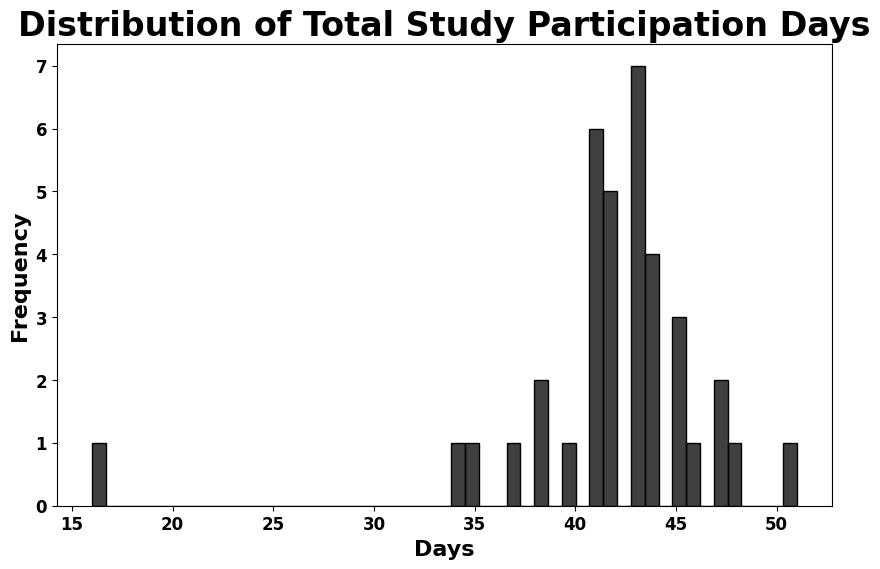

In [5]:
# Read CSV files
steps_gf = pd.read_csv(os.path.join(data_dir, "gfsteps.csv"))
steps_jb = pd.read_csv(os.path.join(data_dir, "jbsteps.csv"))
users_info = pd.read_csv(os.path.join(data_dir, "users.csv"))
suggestions_dat = pd.read_csv(os.path.join(data_dir, "suggestions.csv"))


# Assuming `users_info` DataFrame is already loaded
# Select specific columns
mydata_qs = users_info.filter(regex="user.index|totaldays|^selfeff")


# Reverse Scoring and Summed Variables
mydata_qs = mydata_qs.assign(
    selfeff_badmood_intake_r = 6 - mydata_qs["selfeff.badmood.intake"],
    selfeff_notime_intake_r = 6 - mydata_qs["selfeff.notime.intake"],
    selfeff_tired_intake_r = 6 - mydata_qs["selfeff.tired.intake"],
    selfeff_vaca_intake_r = 6 - mydata_qs["selfeff.vaca.intake"],
    selfeff_precip_intake_r = 6 - mydata_qs["selfeff.precip.intake"],
    
    # Summing intake reverse-scored values
    selfeff_intake_r = lambda x: (
        x["selfeff_notime_intake_r"] + x["selfeff_tired_intake_r"] +
        x["selfeff_vaca_intake_r"] + x["selfeff_precip_intake_r"] +
        x["selfeff_badmood_intake_r"]
    ),

    selfeff_badmood_exit_r = 6 - mydata_qs["selfeff.badmood.exit"],
    selfeff_notime_exit_r = 6 - mydata_qs["selfeff.notime.exit"],
    selfeff_tired_exit_r = 6 - mydata_qs["selfeff.tired.exit"],
    selfeff_vaca_exit_r = 6 - mydata_qs["selfeff.vaca.exit"],
    selfeff_precip_exit_r = 6 - mydata_qs["selfeff.precip.exit"],

    # Summing exit reverse-scored values
    selfeff_exit_r = lambda x: (
        x["selfeff_notime_exit_r"] + x["selfeff_tired_exit_r"] +
        x["selfeff_vaca_exit_r"] + x["selfeff_precip_exit_r"] +
        x["selfeff_badmood_exit_r"]
    )
)


# Histogram of Total Days
plt.figure(figsize=(10, 6))
sns.histplot(mydata_qs['totaldays'], bins=51, color="black", edgecolor="black")
plt.title("Distribution of Total Study Participation Days", fontsize=24, fontweight="bold")
plt.xlabel("Days", fontsize=16, fontweight="bold")
plt.ylabel("Frequency", fontsize=16, fontweight="bold")
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
# plt.gca().set_facecolor("transparent")
plt.savefig(os.path.join(figure_dir,"hist_totalday.png"), transparent=True)
plt.show()

# Creating Notification Type Data
notif_type = suggestions_dat[['user.index', 'decision.index', 'decision.index.nogap', 'send', 'send.active', 'send.sedentary', 'gfsteps30', 'gfsteps60', 'jbsteps30.zero', 'jbsteps60.zero']] 
 
# Merging Data
steps_notif = pd.merge(steps_gf, notif_type, left_on=['user.index', 'decision.index'], right_on=['user.index', 'decision.index'], how='inner')


In [6]:
steps_notif_users = pd.merge(steps_notif, mydata_qs, on='user.index', how='inner')

# Converting columns to boolean
steps_notif_users['send'] = steps_notif_users['send'].astype(bool)
steps_notif_users['send.active'] = steps_notif_users['send.active'].astype(bool)

# Sorting and modifying user.index
steps_notif_users = steps_notif_users.sort_values(by='steps.utime')
steps_notif_users['user.index'] = pd.to_numeric(steps_notif_users['user.index'], errors='coerce')

steps_notif_users = (
    steps_notif_users
    .sort_values(by=['user.index', 'steps.utime', 'decision.index.nogap'])
)

# Summary Statistics
steps_summary = steps_notif_users['steps'].describe()
print(steps_summary)

# Exporting Data to CSV
steps_notif_users.to_csv(os.path.join(data_dir, "steps_notif_users_py.csv"), index=False)


# Filter and transform steps_notif_users
clean_steps_notif_users = (
    steps_notif_users
    # .loc[(steps_notif_users['send'] == True) & (~steps_notif_users['user.index'].isin([29, 22])) & (~steps_notif_users['decision.index.nogap'].isna())]  # Filtering for send == True and excluding users 29 and 22 and those with missing decision index
    .loc[(steps_notif_users['send'] == True) & (~steps_notif_users['user.index'].isin([29, 22]))] 
    .dropna(subset=['steps.utime','decision.index.nogap'])  # Ensure steps.utime is not NA
    .assign(
        notif_type=lambda x: x['send.active'].apply(lambda y: "Active" if y else "Sedentary"),
        steps_date=lambda x: pd.to_datetime(x['steps.utime']).dt.date
    )
    .dropna(subset=['notif_type'])  # Ensure notif_type is not NA
    .sort_values(by=['user.index', 'steps.utime', 'decision.index.nogap'])
    .assign(
        day=lambda x: x.groupby('user.index')['steps_date'].transform(lambda y: pd.factorize(y)[0] + 1)
    )
)


# Summary statistics, filtering, and transformations for mydata_steps_gf
mydata_steps_gf = (
    clean_steps_notif_users
    .loc[:, ['user.index', 'steps_date', 'day', 'notif_type', 'decision.index.nogap','selfeff_intake_r',  'steps', 'gfsteps30', 'gfsteps60', 'jbsteps30.zero', 'jbsteps60.zero']]
    .groupby(['user.index', 'day', 'notif_type', 'decision.index.nogap', 'selfeff_intake_r'], as_index=False)
    .agg(
        n_total=('steps', 'size'),
        n_gf30=('gfsteps30', 'size'),
        n_gf60=('gfsteps60', 'size'),
        n_jb30=('jbsteps30.zero', 'size'),
        n_jb60=('jbsteps60.zero', 'size'),
        total_steps=('steps', 'mean'),
        gfsteps_30=('gfsteps30', 'mean'),
        gfsteps_60=('gfsteps60', 'mean'),
        jbsteps_30=('jbsteps30.zero', 'mean'),
        jbsteps_60=('jbsteps60.zero', 'mean'),
    )
    .assign(
        log_gfsteps_30=lambda x: np.log1p(x['gfsteps_30']), 
        log_gfsteps_60=lambda x: np.log1p(x['gfsteps_60']),
        log_jbsteps_30=lambda x: np.log1p(x['jbsteps_30']),
        log_jbsteps_60=lambda x: np.log1p(x['jbsteps_60']),   
    )
    #.dropna(subset=['total_steps'])  # Filter rows where total_steps is NA
    .sort_values(by=['user.index', 'decision.index.nogap']
))



# View the count of unique users in clean_steps_notif_users and mydata_steps_gf
unique_user_count_clean = clean_steps_notif_users['user.index'].nunique()
unique_user_count_mydata = mydata_steps_gf['user.index'].nunique()

print(f"Unique users in clean_steps_notif_users: {unique_user_count_clean}")
print(f"Unique users in mydata_steps_gf: {unique_user_count_mydata}")

# Exporting Data to CSV
mydata_steps_gf.to_csv(os.path.join(data_dir, "mydata_steps_gf_py.csv"), index=False)




count    196734.000000
mean         27.095804
std          88.395718
min           1.000000
25%           1.000000
50%           4.000000
75%          27.000000
max        4929.000000
Name: steps, dtype: float64
Unique users in clean_steps_notif_users: 25
Unique users in mydata_steps_gf: 25


/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


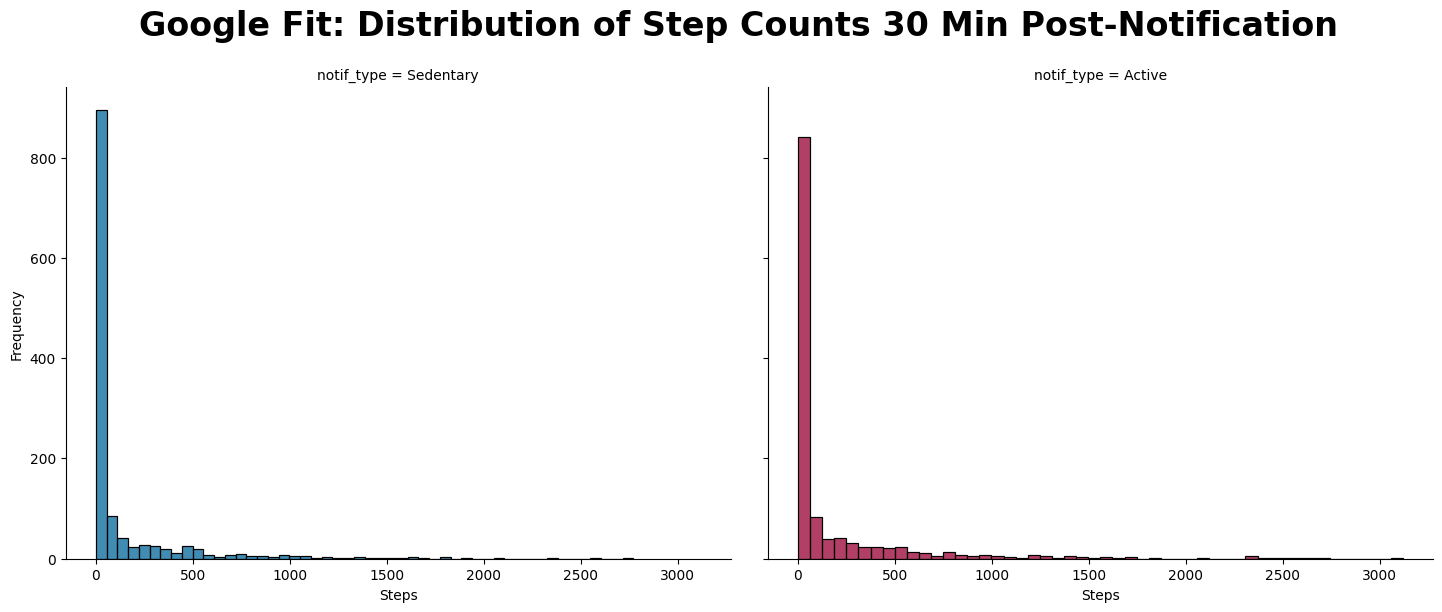

/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


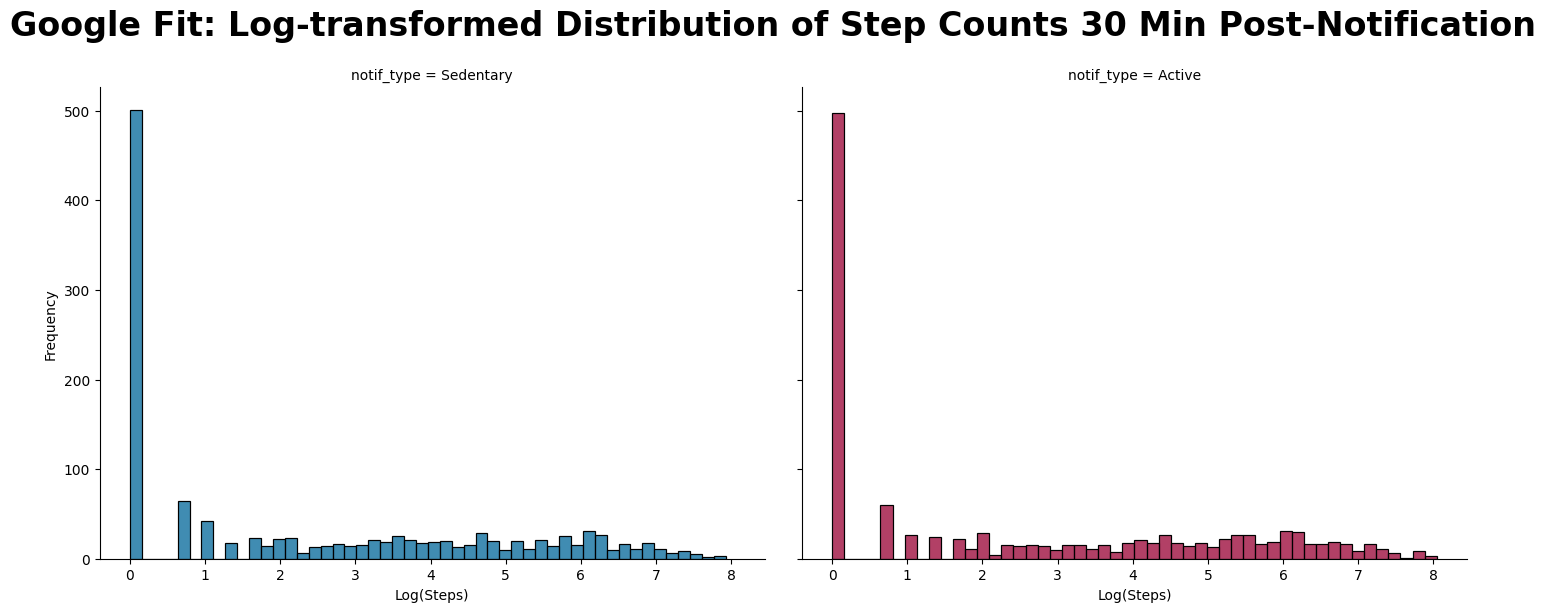

In [7]:
# STEP 1: Check for Normality (Histogram)
# Set up the FacetGrid with 'notif_type' as the facet variable
# Google Fit: 30
mypalette = {"Active": "#006699", "Sedentary": "#990033"}
g = sns.FacetGrid(mydata_steps_gf, col="notif_type", height=6, aspect=1.2, sharex=True, sharey=True, palette=mypalette)
# Map sns.histplot to each facet, using the color for each 'notif_type'
for ax, (notif_type, color) in zip(g.axes.flat, mypalette.items()):
    sns.histplot(
        data=mydata_steps_gf[mydata_steps_gf['notif_type'] == notif_type],
        x="gfsteps_30", bins=50, color=color, edgecolor="black", ax=ax     # changed to plotting step_30 instead of total steps
    )

g.figure.suptitle("Google Fit: Distribution of Step Counts 30 Min Post-Notification", fontsize=24, weight='bold')
g.set_axis_labels("Steps", "Frequency")
plt.subplots_adjust(top=0.85)
# Save the facet-wrapped plot with a transparent background
g.savefig(os.path.join(figure_dir,"gfsteps_30_dist_faceted.png"), transparent=True)
plt.show()

# Log-transformed: GF 30
mypalette = {"Active": "#006699", "Sedentary": "#990033"}
g = sns.FacetGrid(mydata_steps_gf, col="notif_type", height=6, aspect=1.2, sharex=True, sharey=True, palette=mypalette)
for ax, (notif_type, color) in zip(g.axes.flat, mypalette.items()):
    sns.histplot(
        data=mydata_steps_gf[mydata_steps_gf['notif_type'] == notif_type],
        x="log_gfsteps_30", bins=50, color=color, edgecolor="black", ax=ax     # changed to plotting step_30 instead of total steps
    )

g.figure.suptitle("Google Fit: Log-transformed Distribution of Step Counts 30 Min Post-Notification", fontsize=24, weight='bold')
g.set_axis_labels("Log(Steps)", "Frequency")
plt.subplots_adjust(top=0.85)
# Save the facet-wrapped plot with a transparent background
g.savefig(os.path.join(figure_dir,"log_gfsteps_30_dist_faceted.png"), transparent=True)
plt.show()



/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


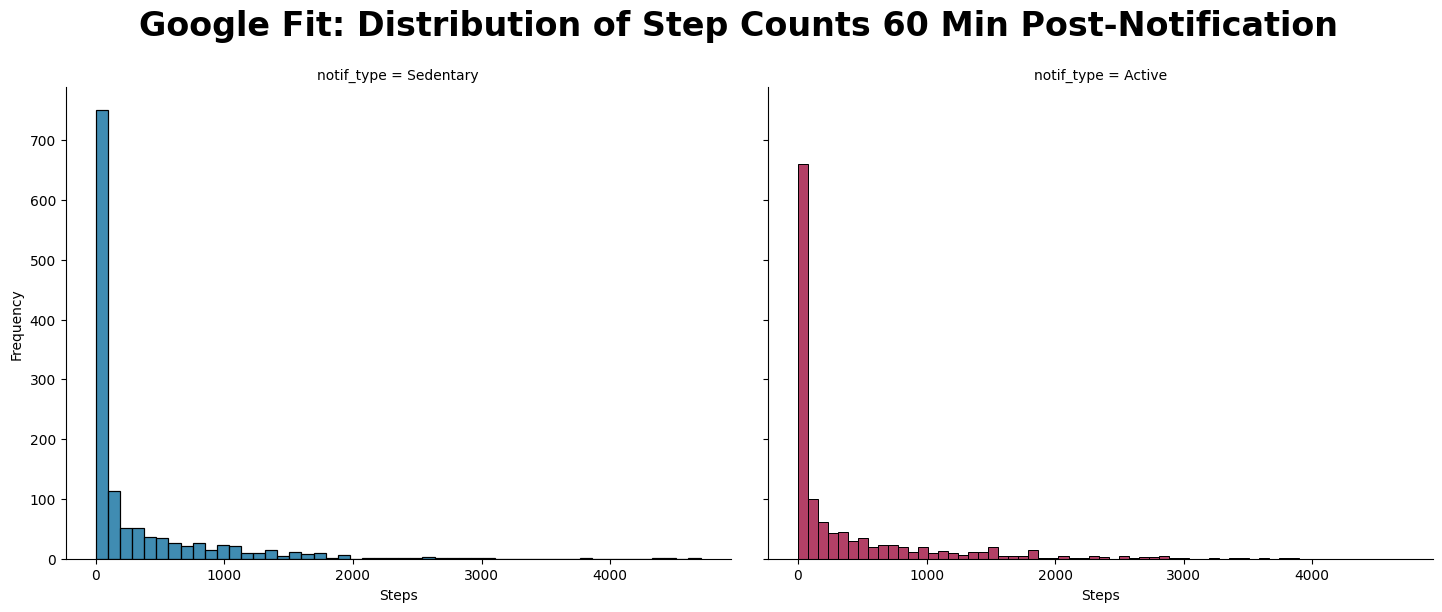

/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


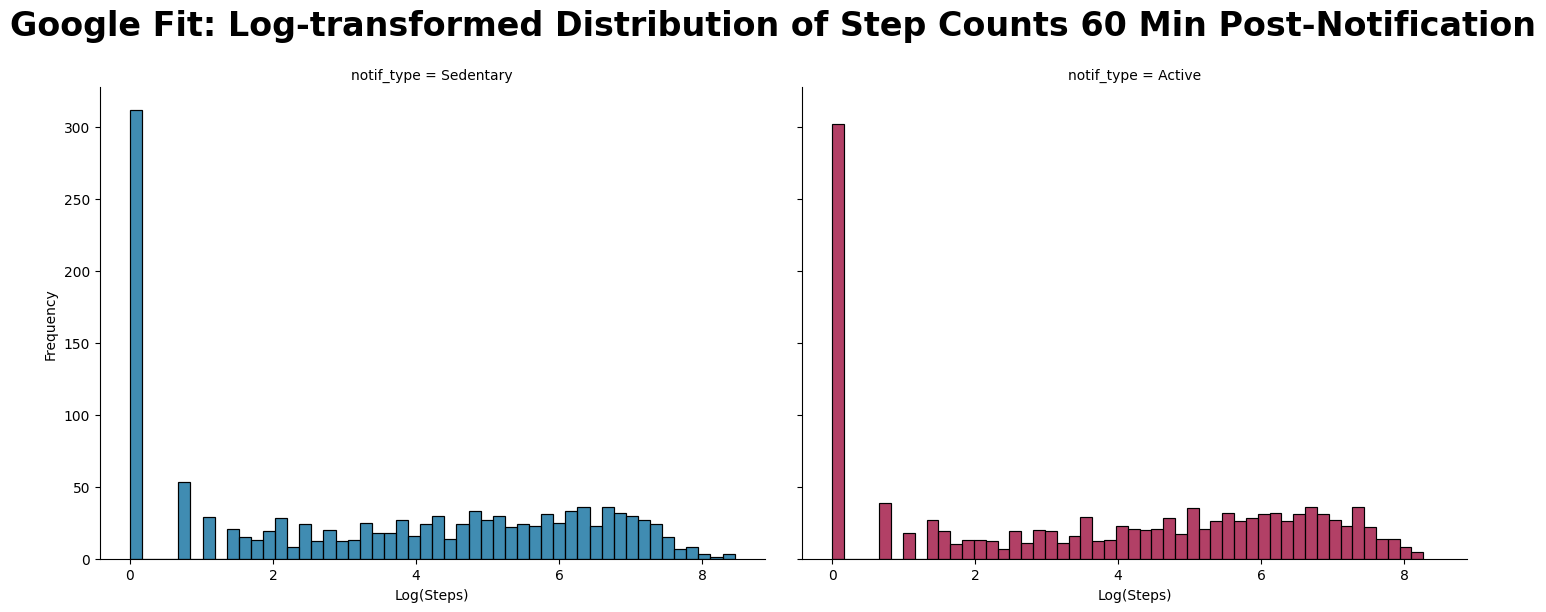

In [8]:
mypalette = {"Active": "#006699", "Sedentary": "#990033"}
g = sns.FacetGrid(mydata_steps_gf, col="notif_type", height=6, aspect=1.2, sharex=True, sharey=True, palette=mypalette)
# Map sns.histplot to each facet, using the color for each 'notif_type'
# Google Fit: 60
for ax, (notif_type, color) in zip(g.axes.flat, mypalette.items()):
    sns.histplot(
        data=mydata_steps_gf[mydata_steps_gf['notif_type'] == notif_type],
        x="gfsteps_60", bins=50, color=color, edgecolor="black", ax=ax     # changed to plotting step_30 instead of total steps
    )

g.figure.suptitle("Google Fit: Distribution of Step Counts 60 Min Post-Notification", fontsize=24, weight='bold')
g.set_axis_labels("Steps", "Frequency")
plt.subplots_adjust(top=0.85)
# Save the facet-wrapped plot with a transparent background
g.savefig(os.path.join(figure_dir,"gfsteps_60_dist_faceted.png"), transparent=True)
plt.show()

# Log-transformed: GF 600
mypalette = {"Active": "#006699", "Sedentary": "#990033"}
g = sns.FacetGrid(mydata_steps_gf, col="notif_type", height=6, aspect=1.2, sharex=True, sharey=True, palette=mypalette)
for ax, (notif_type, color) in zip(g.axes.flat, mypalette.items()):
    sns.histplot(
        data=mydata_steps_gf[mydata_steps_gf['notif_type'] == notif_type],
        x="log_gfsteps_60", bins=50, color=color, edgecolor="black", ax=ax     # changed to plotting step_30 instead of total steps
    )

g.figure.suptitle("Google Fit: Log-transformed Distribution of Step Counts 60 Min Post-Notification", fontsize=24, weight='bold')
g.set_axis_labels("Log(Steps)", "Frequency")
plt.subplots_adjust(top=0.85)
# Save the facet-wrapped plot with a transparent background
g.savefig(os.path.join(figure_dir,"log_gfsteps_60_dist_faceted.png"), transparent=True)
plt.show()



/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


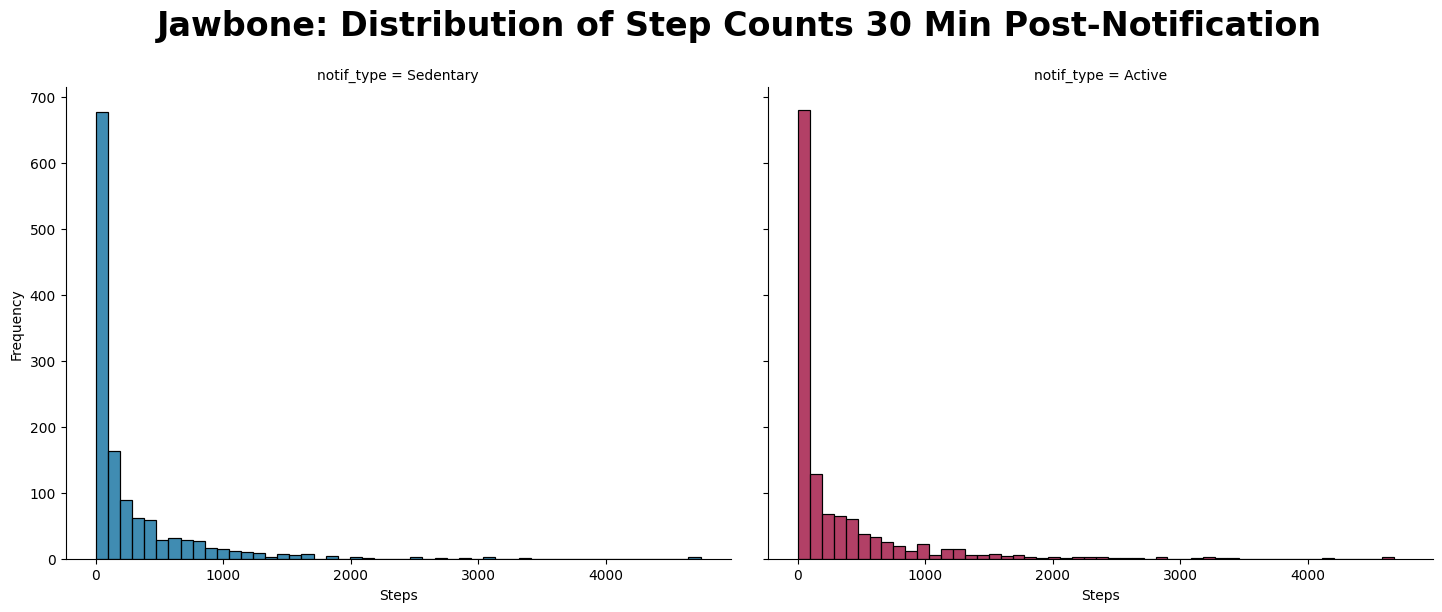

/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


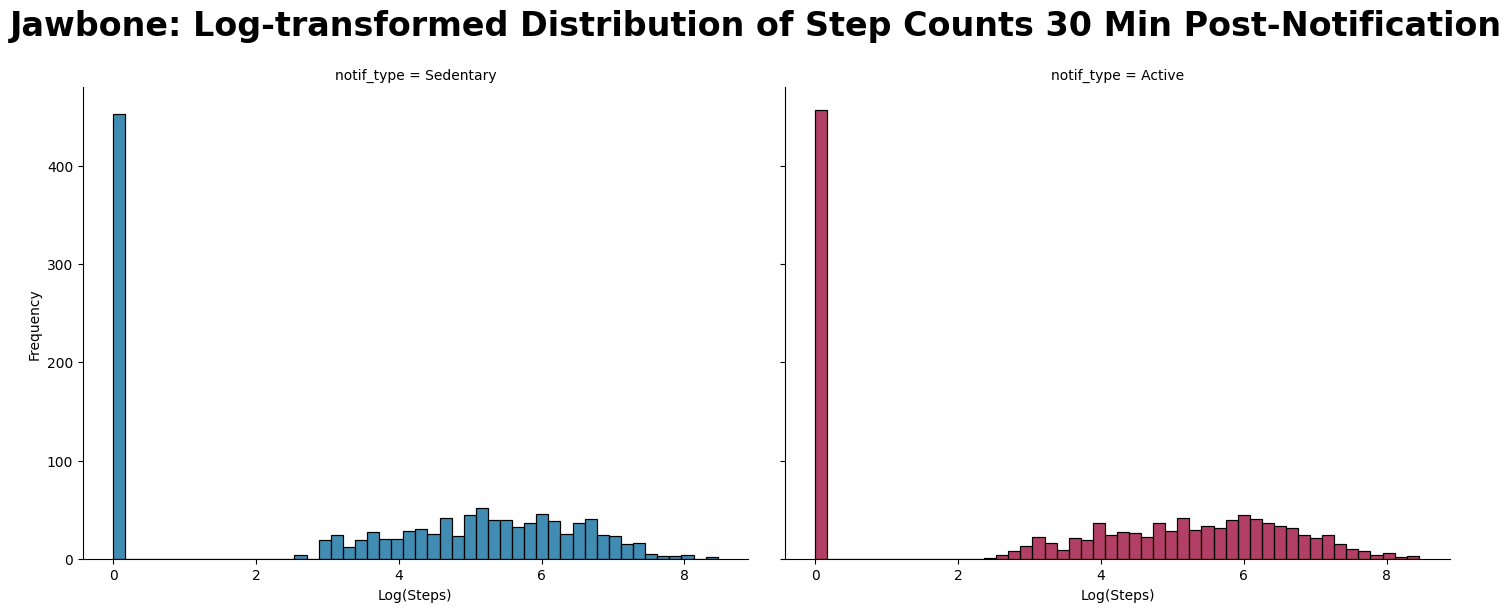

In [9]:
mypalette = {"Active": "#006699", "Sedentary": "#990033"}
g = sns.FacetGrid(mydata_steps_gf, col="notif_type", height=6, aspect=1.2, sharex=True, sharey=True, palette=mypalette)
# Map sns.histplot to each facet, using the color for each 'notif_type'
# Jawbone: 30
# Map sns.histplot to each facet, using the color for each 'notif_type'
for ax, (notif_type, color) in zip(g.axes.flat, mypalette.items()):
    sns.histplot(
        data=mydata_steps_gf[mydata_steps_gf['notif_type'] == notif_type],
        x="jbsteps_30", bins=50, color=color, edgecolor="black", ax=ax     # changed to plotting step_30 instead of total steps
    )

g.figure.suptitle("Jawbone: Distribution of Step Counts 30 Min Post-Notification", fontsize=24, weight='bold')
g.set_axis_labels("Steps", "Frequency")
plt.subplots_adjust(top=0.85)
# Save the facet-wrapped plot with a transparent background
g.savefig(os.path.join(figure_dir,"jbsteps_30_dist_faceted.png"), transparent=True)
plt.show()

# Log-transformed: JB 30
mypalette = {"Active": "#006699", "Sedentary": "#990033"}
g = sns.FacetGrid(mydata_steps_gf, col="notif_type", height=6, aspect=1.2, sharex=True, sharey=True, palette=mypalette)
for ax, (notif_type, color) in zip(g.axes.flat, mypalette.items()):
    sns.histplot(
        data=mydata_steps_gf[mydata_steps_gf['notif_type'] == notif_type],
        x="log_jbsteps_30", bins=50, color=color, edgecolor="black", ax=ax     # changed to plotting step_30 instead of total steps
    )

g.figure.suptitle("Jawbone: Log-transformed Distribution of Step Counts 30 Min Post-Notification", fontsize=24, weight='bold')
g.set_axis_labels("Log(Steps)", "Frequency")
plt.subplots_adjust(top=0.85)
# Save the facet-wrapped plot with a transparent background
g.savefig(os.path.join(figure_dir,"log_jbsteps_30_dist_faceted.png"), transparent=True)
plt.show()


/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


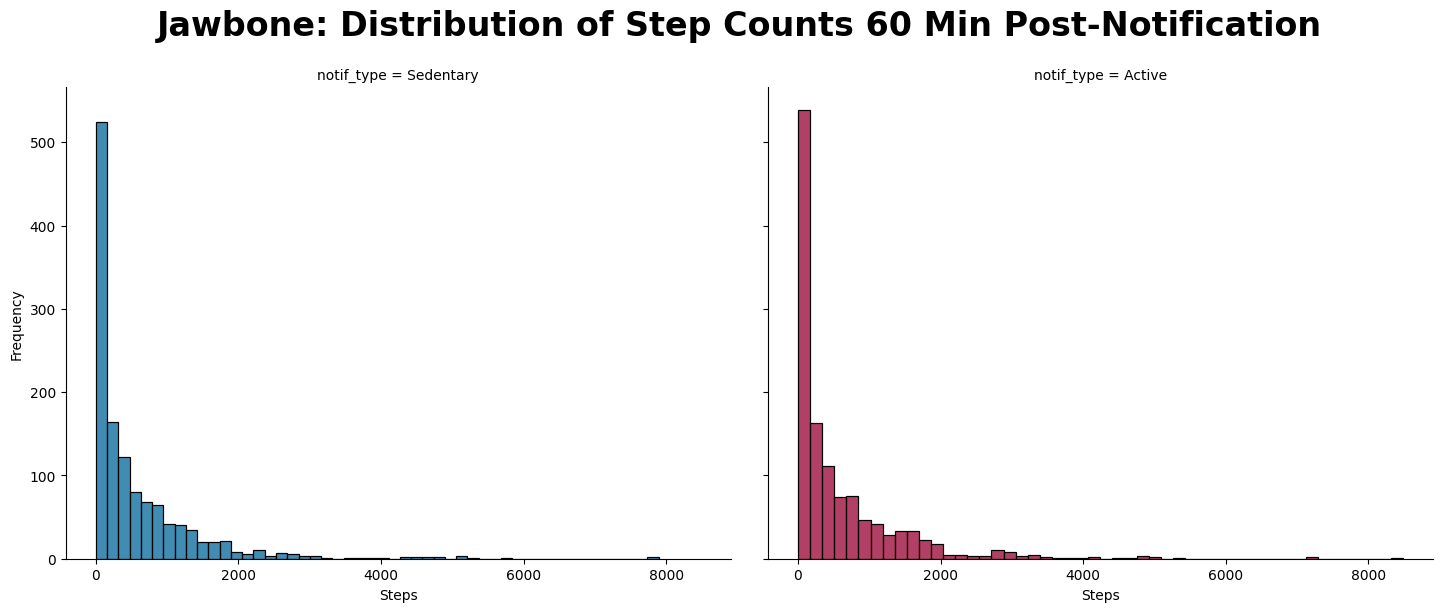

/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


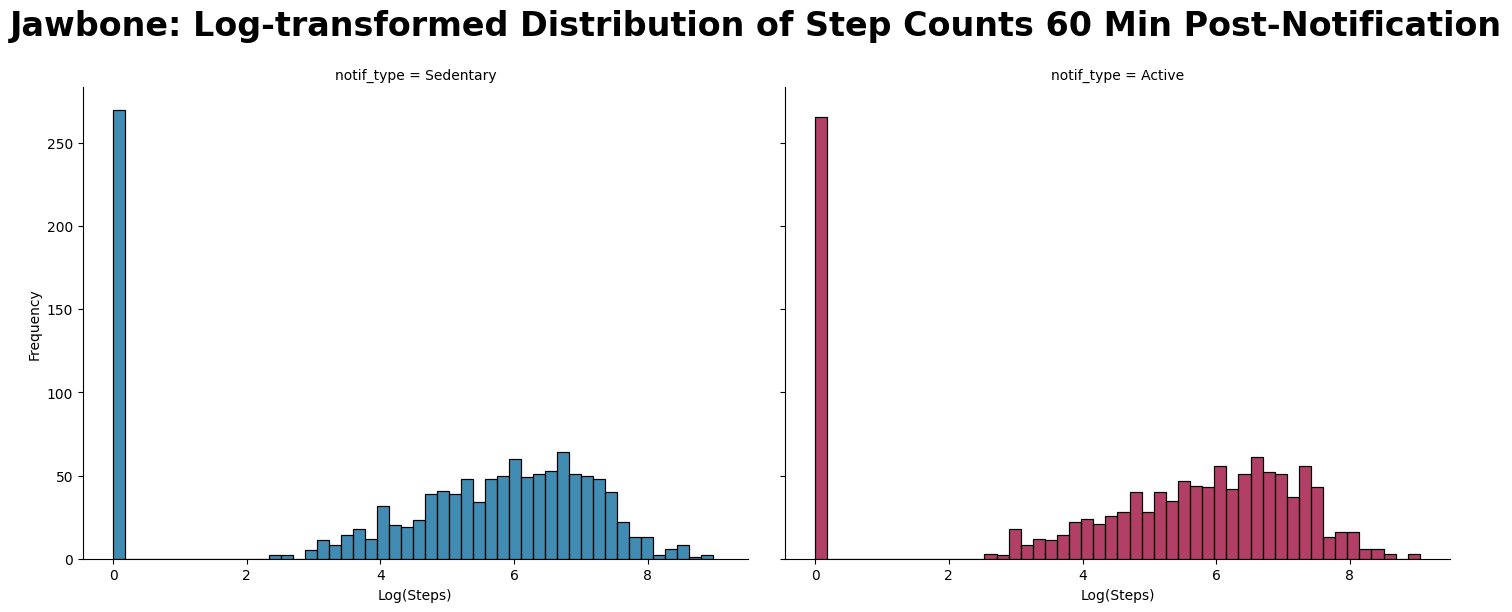

In [10]:
mypalette = {"Active": "#006699", "Sedentary": "#990033"}
g = sns.FacetGrid(mydata_steps_gf, col="notif_type", height=6, aspect=1.2, sharex=True, sharey=True, palette=mypalette)
# Map sns.histplot to each facet, using the color for each 'notif_type'
# Jawbone: 60
# Map sns.histplot to each facet, using the color for each 'notif_type'
for ax, (notif_type, color) in zip(g.axes.flat, mypalette.items()):
    sns.histplot(
        data=mydata_steps_gf[mydata_steps_gf['notif_type'] == notif_type],
        x="jbsteps_60", bins=50, color=color, edgecolor="black", ax=ax     # changed to plotting step_30 instead of total steps
    )

g.figure.suptitle("Jawbone: Distribution of Step Counts 60 Min Post-Notification", fontsize=24, weight='bold')
g.set_axis_labels("Steps", "Frequency")
plt.subplots_adjust(top=0.85)
# Save the facet-wrapped plot with a transparent background
g.savefig(os.path.join(figure_dir,"jbsteps_60_dist_faceted.png"), transparent=True)
plt.show()

# Log-transformed: JB 60
mypalette = {"Active": "#006699", "Sedentary": "#990033"}
g = sns.FacetGrid(mydata_steps_gf, col="notif_type", height=6, aspect=1.2, sharex=True, sharey=True, palette=mypalette)
for ax, (notif_type, color) in zip(g.axes.flat, mypalette.items()):
    sns.histplot(
        data=mydata_steps_gf[mydata_steps_gf['notif_type'] == notif_type],
        x="log_jbsteps_60", bins=50, color=color, edgecolor="black", ax=ax     # changed to plotting step_30 instead of total steps
    )

g.figure.suptitle("Jawbone: Log-transformed Distribution of Step Counts 60 Min Post-Notification", fontsize=24, weight='bold')
g.set_axis_labels("Log(Steps)", "Frequency")
plt.subplots_adjust(top=0.85)
# Save the facet-wrapped plot with a transparent background
g.savefig(os.path.join(figure_dir,"log_jbsteps_60_dist_faceted.png"), transparent=True)
plt.show()

In [11]:
# STEP 2: Check for Overdispersion (Summary Statistics)
# Melt data to long format (similar to `gather`)
melted_data = pd.melt(
    clean_steps_notif_users, 
    id_vars=['notif_type'], 
    value_vars=['steps', 'selfeff_intake_r'],
    var_name='key', 
    value_name='value'
)

# Group by and calculate summary statistics
SUMM_mydata_steps_gf = (
    melted_data
    .groupby(['notif_type', 'key'])
    .agg(
        n=('value', 'size'),
        mean=('value', lambda x: round(np.mean(x.dropna()), 1)),
        var=('value', lambda x: round(np.var(x.dropna()), 1)),
        sd=('value', lambda x: round(np.std(x.dropna()), 1)),
        se=('value', lambda x: round(np.std(x.dropna()) / np.sqrt(x.notna().sum()), 1)),
        median=('value', lambda x: round(np.median(x.dropna()), 1)),
        IQR=('value', lambda x: round(np.percentile(x.dropna(), 75) - np.percentile(x.dropna(), 25), 1))
    )
).reset_index()

# Display summary statistics
print(SUMM_mydata_steps_gf)


  notif_type               key      n  mean     var    sd   se  median   IQR
0     Active  selfeff_intake_r  46478  15.0    12.4   3.5  0.0    15.0   5.0
1     Active             steps  46478  27.0  6720.1  82.0  0.4     4.0  27.0
2  Sedentary  selfeff_intake_r  42490  14.8    14.2   3.8  0.0    15.0   5.0
3  Sedentary             steps  42490  29.2  9407.0  97.0  0.5     4.0  28.0


# EDA 


## RQ 1a: Effects of Framing Styles on Step Counts
    - GF: 
        - 30 after ~ notif_type
        - 60 after ~ notif_type

    - JAWBONE: 
        - 30 after ~ notif_type
        - 60 after ~ notif_type


                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     total_steps
No. Observations:     2512        Method:                 REML       
No. Groups:           25          Scale:                  9661.1267  
Min. group size:      23          Log-Likelihood:         -15127.7564
Max. group size:      134         Converged:              Yes        
Mean group size:      100.5                                          
---------------------------------------------------------------------
                         Coef.   Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
Intercept                 43.085   12.496  3.448 0.001  18.594 67.577
notif_type[T.Sedentary]   -2.486    3.994 -0.622 0.534 -10.314  5.343
Group Var               3696.529   11.177                            



/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_79487/793955025.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_summary = mydata_steps_gf.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


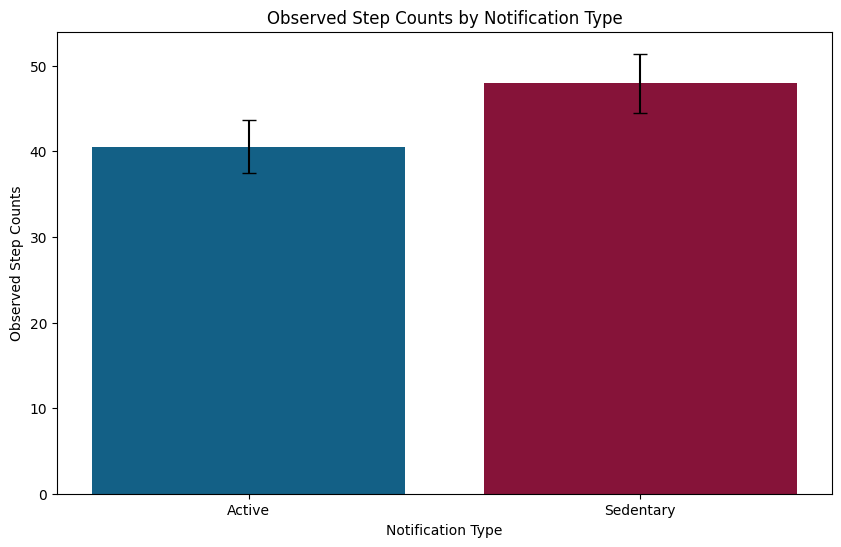

In [12]:
#====================================================================
# RQ 1: Effects of Framing Styles on Step Counts
# GF DATA: total between notif, 30min post notif, 60min post notif
#====================================================================

# load data
# mydata_steps_gf <- pd.read_csv(os.path.join(data_dir, "mydata_steps_gf_py.csv"))
mydata_steps_gf['user.index'] = mydata_steps_gf['user.index'].astype(str).astype('category')
mydata_steps_gf['notif_type'] = mydata_steps_gf['notif_type'].astype('category')

mydata_steps_gf = mydata_steps_gf

from statsmodels.formula.api import mixedlm

#====================================================================
# GF DATA: total between notif (total_steps)
#====================================================================
# Define the model and fit (approximate approach using MixedLM)
model_nb_glmm = mixedlm("total_steps ~ notif_type", mydata_steps_gf, groups=mydata_steps_gf["user.index"])
result = model_nb_glmm.fit()
print(result.summary())

# # Add predicted values into dataframe and 
# # Create a summary of predicted values for plotting
# mydata_steps_gf['predicted_steps'] = result.predict()
# predictions_summary = mydata_steps_gf.groupby('notif_type').agg(
#     mean_pred=('predicted_steps', 'mean'),
#     lower_ci=('predicted_steps', lambda x: np.quantile(x, 0.025)),
#     upper_ci=('predicted_steps', lambda x: np.quantile(x, 0.975)),
#     se_pred=('predicted_steps', lambda x: np.std(x) / np.sqrt(len(x)))
# ).reset_index()

# # plot PREDICTED values 
# plt.figure(figsize=(10, 6))
# sns.barplot(data=predictions_summary, x="notif_type", y="mean_pred", palette={"Active": "#006699", "Sedentary": "#990033"})
# plt.errorbar(predictions_summary['notif_type'], predictions_summary['mean_pred'], 
#              yerr=predictions_summary['se_pred'], fmt='none', color='black', capsize=5)
# plt.title("Predicted Step Counts by Notification Type")
# plt.xlabel("Notification Type")
# plt.ylabel("Predicted Step Counts")
# plt.savefig(os.path.join(figure_dir, "pred_rq1.png"), transparent=True)
# plt.show()

# Add OBSERVED values into dataframe and create a summary for plotting
observed_summary = mydata_steps_gf.groupby('notif_type').agg(
    mean_obs=('total_steps', 'mean'),
    lower_ci=('total_steps', lambda x: np.quantile(x, 0.025)),
    upper_ci=('total_steps', lambda x: np.quantile(x, 0.975)),
    se_obs=('total_steps', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# plot OBSERVED values 
plt.figure(figsize=(10, 6))
sns.barplot(data=observed_summary, x="notif_type", y="mean_obs", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(observed_summary['notif_type'], observed_summary['mean_obs'], 
             yerr=observed_summary['se_obs'], fmt='none', color='black', capsize=5)
plt.title("Observed Step Counts by Notification Type")
plt.xlabel("Notification Type")
plt.ylabel("Observed Step Counts")
plt.savefig(os.path.join(figure_dir,"obs_rq1.png"), transparent=True)
plt.show()



# Start of analyses with the JAWBONE DATASET 


#====================================================================
# JAWBONE DATA: total between notif (total_steps)
#====================================================================
# we need to do the same thing as the steps we did above, but now for the steps 30-min post the notification


#====================================================================
# JAWBONE DATA: total steps 30 min after notif (total_steps_30)
#====================================================================
# we need to do the same thing as the steps we did above, but now for the steps 30-min post the notification


#====================================================================
# JAWBONE DATA: total steps 60 min after notif (total_steps_60)
#====================================================================
# we need to do the same thing as the steps we did above, but now for the steps 60-min post the notification

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     gfsteps_30 
No. Observations:     2512        Method:                 REML       
No. Groups:           25          Scale:                  121097.8734
Min. group size:      23          Log-Likelihood:         -18276.9545
Max. group size:      134         Converged:              Yes        
Mean group size:      100.5                                          
---------------------------------------------------------------------
                         Coef.   Std.Err.   z   P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept                135.199   17.420 7.761 0.000 101.056 169.342
notif_type[T.Sedentary]   26.781   14.103 1.899 0.058  -0.860  54.422
Group Var               5053.977    5.173                            



/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_79487/924677415.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_summary_30 = mydata_steps_gf.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


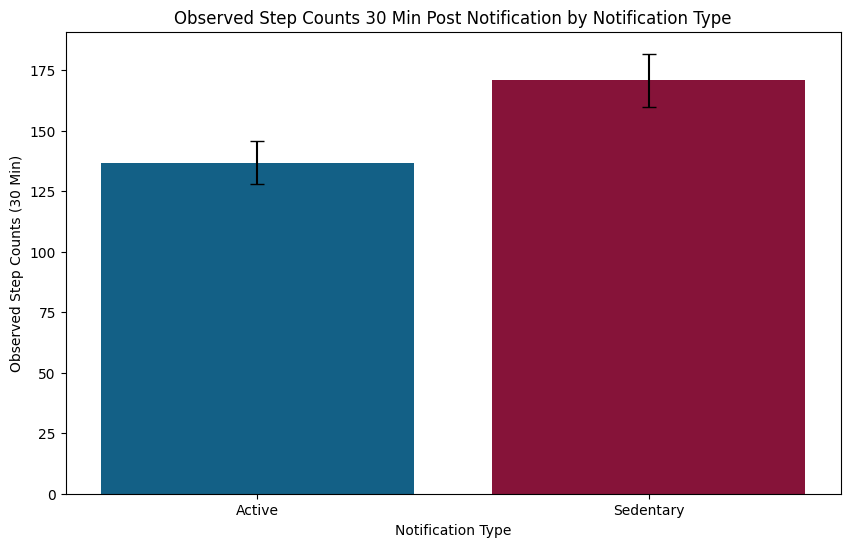

              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  log_gfsteps_30
No. Observations:    2512     Method:              REML          
No. Groups:          25       Scale:               6.1267        
Min. group size:     23       Log-Likelihood:      -5862.2719    
Max. group size:     134      Converged:           Yes           
Mean group size:     100.5                                       
-----------------------------------------------------------------
                        Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               2.349    0.121 19.363 0.000  2.111  2.587
notif_type[T.Sedentary] 0.105    0.100  1.052 0.293 -0.091  0.302
Group Var               0.240    0.036                           



/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_79487/924677415.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_summary_30 = mydata_steps_gf.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


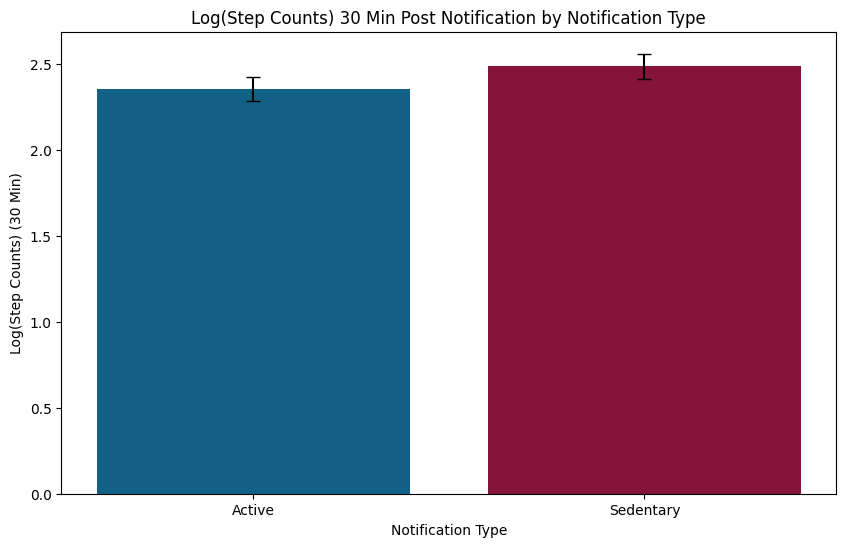

In [13]:
#====================================================================
# GF DATA: total steps 30 min after notif (gfsteps30)
#====================================================================
# we need to do the same thing as the steps we did above, but now for the steps 30-min post the notification
# print(mydata_steps_gf[['gfsteps30', 'notif_type', 'user.index']].isnull().sum())
# Filter out rows where 'gfsteps30' is NaN
# Filter out rows where 'gfsteps30' or 'gfsteps60' are NaN
# mydata_steps_gf = mydata_steps_gf.dropna(subset=['gfsteps30', 'gfsteps60']).reset_index(drop=True)
# mydata_steps_gf = mydata_steps_gf

from statsmodels.formula.api import mixedlm

# Define the model and fit (approximate approach using MixedLM)
model_gf30_glmm = mixedlm("gfsteps_30 ~ notif_type", mydata_steps_gf, groups=mydata_steps_gf["user.index"])
result_gf30 = model_gf30_glmm.fit()
print(result_gf30.summary())

# # Add predicted values into dataframe and 
# # Create a summary of predicted values for plotting
# mydata_steps_gf['predicted_steps_30'] = result_gf30.predict()
# predictions_summary_30 = mydata_steps_gf.groupby('notif_type').agg(
#     mean_pred=('predicted_steps_30', 'mean'),
#     lower_ci=('predicted_steps_30', lambda x: np.quantile(x, 0.025)),
#     upper_ci=('predicted_steps_30', lambda x: np.quantile(x, 0.975)),
#     se_pred=('predicted_steps_30', lambda x: np.std(x) / np.sqrt(len(x)))
# ).reset_index()

# # Plot PREDICTED values for gfsteps30
# plt.figure(figsize=(10, 6))
# sns.barplot(data=predictions_summary_30, x="notif_type", y="mean_pred", palette={"Active": "#006699", "Sedentary": "#990033"})
# plt.errorbar(predictions_summary_30['notif_type'], predictions_summary_30['mean_pred'], 
#              yerr=predictions_summary_30['se_pred'], fmt='none', color='black', capsize=5)
# plt.title("Predicted Step Counts 30 Min Post Notification by Notification Type")
# plt.xlabel("Notification Type")
# plt.ylabel("Predicted Step Counts (30 Min)")
# plt.savefig(os.path.join(figure_dir, "pred_rq1_30min.png"), transparent=True)
# plt.show()

# Add OBSERVED values into dataframe and create a summary for plotting
observed_summary_30 = mydata_steps_gf.groupby('notif_type').agg(
    mean_obs=('gfsteps_30', 'mean'),
    lower_ci=('gfsteps_30', lambda x: np.quantile(x, 0.025)),
    upper_ci=('gfsteps_30', lambda x: np.quantile(x, 0.975)),
    se_obs=('gfsteps_30', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot OBSERVED values for gfsteps30
plt.figure(figsize=(10, 6))
sns.barplot(data=observed_summary_30, x="notif_type", y="mean_obs", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(observed_summary_30['notif_type'], observed_summary_30['mean_obs'], 
             yerr=observed_summary_30['se_obs'], fmt='none', color='black', capsize=5)
plt.title("Observed Step Counts 30 Min Post Notification by Notification Type")
plt.xlabel("Notification Type")
plt.ylabel("Observed Step Counts (30 Min)")
plt.savefig(os.path.join(figure_dir, "obs_rq1_30min.png"), transparent=True)
plt.show()



#log-transformed GF 30
from statsmodels.formula.api import mixedlm

# Define the model and fit (approximate approach using MixedLM)
model_gf30_glmm_log = mixedlm("log_gfsteps_30 ~ notif_type", mydata_steps_gf, groups=mydata_steps_gf["user.index"])
result_gf30_log = model_gf30_glmm_log.fit()
print(result_gf30_log.summary())


# Add OBSERVED values into dataframe and create a summary for plotting
observed_summary_30 = mydata_steps_gf.groupby('notif_type').agg(
    mean_obs=('log_gfsteps_30', 'mean'),
    lower_ci=('log_gfsteps_30', lambda x: np.quantile(x, 0.025)),
    upper_ci=('log_gfsteps_30', lambda x: np.quantile(x, 0.975)),
    se_obs=('log_gfsteps_30', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot OBSERVED values for gfsteps30
plt.figure(figsize=(10, 6))
sns.barplot(data=observed_summary_30, x="notif_type", y="mean_obs", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(observed_summary_30['notif_type'], observed_summary_30['mean_obs'], 
             yerr=observed_summary_30['se_obs'], fmt='none', color='black', capsize=5)
plt.title("Log(Step Counts) 30 Min Post Notification by Notification Type")
plt.xlabel("Notification Type")
plt.ylabel("Log(Step Counts) (30 Min)")
plt.savefig(os.path.join(figure_dir, "obs_rq1_30min_log.png"), transparent=True)
plt.show()


                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     gfsteps_60 
No. Observations:      2512        Method:                 REML       
No. Groups:            25          Scale:                  315051.0868
Min. group size:       23          Log-Likelihood:         -19482.5647
Max. group size:       134         Converged:              Yes        
Mean group size:       100.5                                          
----------------------------------------------------------------------
                          Coef.   Std.Err.   z   P>|z|  [0.025  0.975]
----------------------------------------------------------------------
Intercept                 286.089   34.555 8.279 0.000 218.363 353.815
notif_type[T.Sedentary]    56.454   22.767 2.480 0.013  11.833 101.076
Group Var               23194.141   13.567                            



/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_79487/3545112076.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_summary_60 = mydata_steps_gf.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


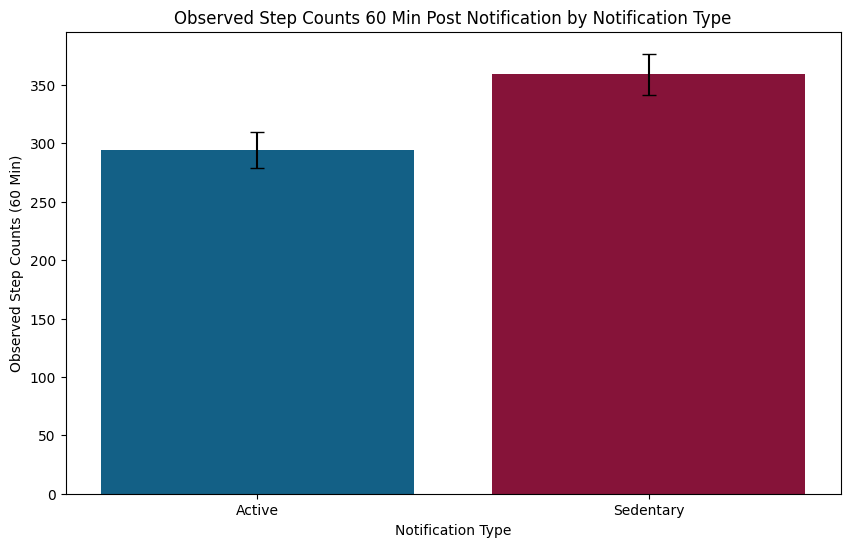

              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  log_gfsteps_60
No. Observations:    2512     Method:              REML          
No. Groups:          25       Scale:               6.6922        
Min. group size:     23       Log-Likelihood:      -5980.0107    
Max. group size:     134      Converged:           Yes           
Mean group size:     100.5                                       
-----------------------------------------------------------------
                        Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               3.399    0.163 20.810 0.000  3.079  3.719
notif_type[T.Sedentary] 0.199    0.105  1.895 0.058 -0.007  0.404
Group Var               0.525    0.067                           



/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_79487/3545112076.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_summary_60 = mydata_steps_gf.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


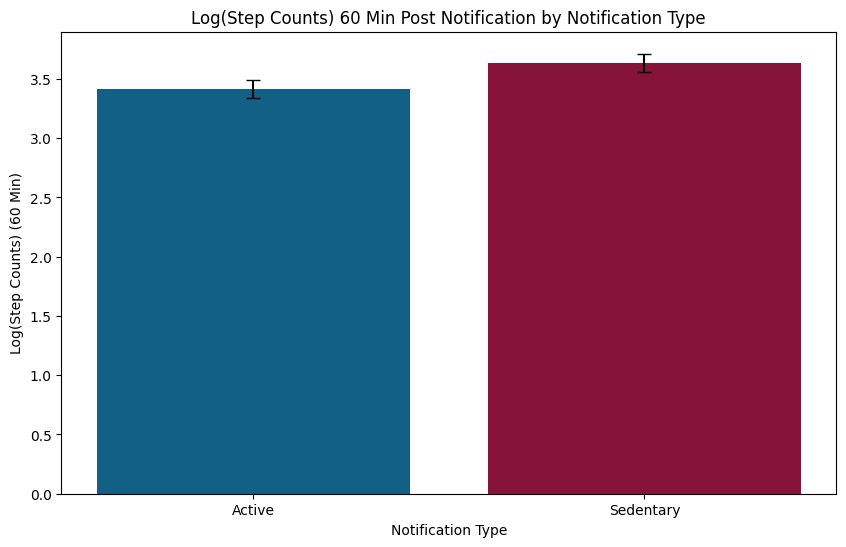

In [14]:

#====================================================================
# GF DATA: total steps 60 min after notif (gfsteps60)
#====================================================================
# we need to do the same thing as the steps we did above, but now for the steps 60-min post the notification
# print(mydata_steps_gf[['gfsteps60', 'notif_type', 'user.index']].isnull().sum())
# Filter out rows where 'gfsteps60' is NaN
# Filter out rows where 'gfsteps60' or 'gfsteps60' are NaN
# mydata_steps_gf = mydata_steps_gf.dropna(subset=['gfsteps60', 'gfsteps60']).reset_index(drop=True)
# mydata_steps_gf = mydata_steps_gf

from statsmodels.formula.api import mixedlm

# Define the model and fit (approximate approach using MixedLM)
model_gf60_glmm = mixedlm("gfsteps_60 ~ notif_type", mydata_steps_gf, groups=mydata_steps_gf["user.index"])
result_gf60 = model_gf60_glmm.fit()
print(result_gf60.summary())

# # Add predicted values into dataframe and 
# # Create a summary of predicted values for plotting
# mydata_steps_gf['predicted_steps_60'] = result_gf60.predict()
# predictions_summary_60 = mydata_steps_gf.groupby('notif_type').agg(
#     mean_pred=('predicted_steps_60', 'mean'),
#     lower_ci=('predicted_steps_60', lambda x: np.quantile(x, 0.025)),
#     upper_ci=('predicted_steps_60', lambda x: np.quantile(x, 0.975)),
#     se_pred=('predicted_steps_60', lambda x: np.std(x) / np.sqrt(len(x)))
# ).reset_index()

# # Plot PREDICTED values for gfsteps60
# plt.figure(figsize=(10, 6))
# sns.barplot(data=predictions_summary_60, x="notif_type", y="mean_pred", palette={"Active": "#006699", "Sedentary": "#990033"})
# plt.errorbar(predictions_summary_60['notif_type'], predictions_summary_60['mean_pred'], 
#              yerr=predictions_summary_60['se_pred'], fmt='none', color='black', capsize=5)
# plt.title("Predicted Step Counts 60 Min Post Notification by Notification Type")
# plt.xlabel("Notification Type")
# plt.ylabel("Predicted Step Counts (60 Min)")
# plt.savefig(os.path.join(figure_dir, "pred_rq1_60min.png"), transparent=True)
# plt.show()

# Add OBSERVED values into dataframe and create a summary for plotting
observed_summary_60 = mydata_steps_gf.groupby('notif_type').agg(
    mean_obs=('gfsteps_60', 'mean'),
    lower_ci=('gfsteps_60', lambda x: np.quantile(x, 0.025)),
    upper_ci=('gfsteps_60', lambda x: np.quantile(x, 0.975)),
    se_obs=('gfsteps_60', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot OBSERVED values for gfsteps60
plt.figure(figsize=(10, 6))
sns.barplot(data=observed_summary_60, x="notif_type", y="mean_obs", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(observed_summary_60['notif_type'], observed_summary_60['mean_obs'], 
             yerr=observed_summary_60['se_obs'], fmt='none', color='black', capsize=5)
plt.title("Observed Step Counts 60 Min Post Notification by Notification Type")
plt.xlabel("Notification Type")
plt.ylabel("Observed Step Counts (60 Min)")
plt.savefig(os.path.join(figure_dir, "obs_rq1_60min.png"), transparent=True)
plt.show()



#log-transformed GF 60
from statsmodels.formula.api import mixedlm

# Define the model and fit (approximate approach using MixedLM)
model_gf60_glmm_log = mixedlm("log_gfsteps_60 ~ notif_type", mydata_steps_gf, groups=mydata_steps_gf["user.index"])
result_gf60_log = model_gf60_glmm_log.fit()
print(result_gf60_log.summary())


# Add OBSERVED values into dataframe and create a summary for plotting
observed_summary_60 = mydata_steps_gf.groupby('notif_type').agg(
    mean_obs=('log_gfsteps_60', 'mean'),
    lower_ci=('log_gfsteps_60', lambda x: np.quantile(x, 0.025)),
    upper_ci=('log_gfsteps_60', lambda x: np.quantile(x, 0.975)),
    se_obs=('log_gfsteps_60', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot OBSERVED values for gfsteps60
plt.figure(figsize=(10, 6))
sns.barplot(data=observed_summary_60, x="notif_type", y="mean_obs", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(observed_summary_60['notif_type'], observed_summary_60['mean_obs'], 
             yerr=observed_summary_60['se_obs'], fmt='none', color='black', capsize=5)
plt.title("Log(Step Counts) 60 Min Post Notification by Notification Type")
plt.xlabel("Notification Type")
plt.ylabel("Log(Step Counts) (60 Min)")
plt.savefig(os.path.join(figure_dir, "obs_rq1_60min_log.png"), transparent=True)
plt.show()



/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_79487/3420896698.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_summary_30 = mydata_steps_gf.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     jbsteps_30 
No. Observations:      2512        Method:                 REML       
No. Groups:            25          Scale:                  227825.6641
Min. group size:       23          Log-Likelihood:         -19069.4957
Max. group size:       134         Converged:              Yes        
Mean group size:       100.5                                          
----------------------------------------------------------------------
                         Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------------
Intercept                253.591   23.394 10.840 0.000 207.739 299.442
notif_type[T.Sedentary]   28.557   19.332  1.477 0.140  -9.332  66.447
Group Var               8925.709    6.824                             



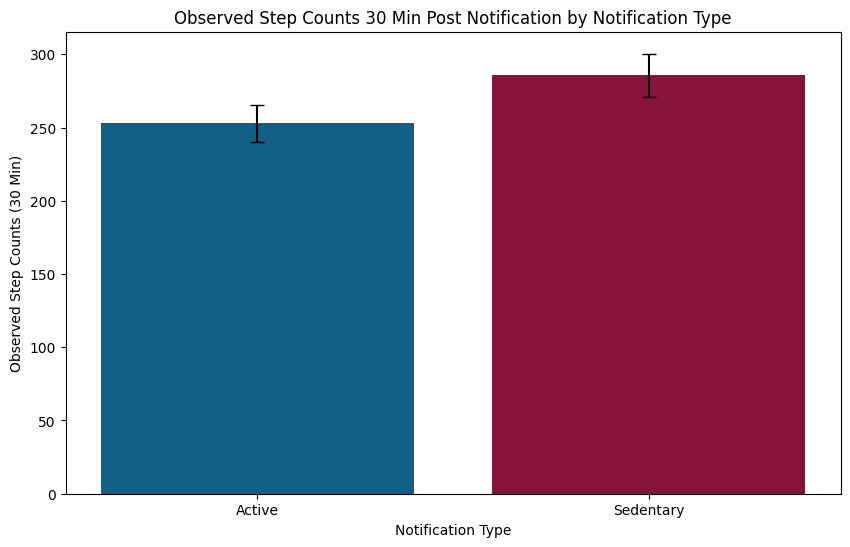

/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_79487/3420896698.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_summary_30 = mydata_steps_gf.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   log_jbsteps_30
No. Observations:   2512      Method:               REML          
No. Groups:         25        Scale:                7.3346        
Min. group size:    23        Log-Likelihood:       -6088.2763    
Max. group size:    134       Converged:            Yes           
Mean group size:    100.5                                         
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                3.432    0.134 25.700 0.000  3.171  3.694
notif_type[T.Sedentary] -0.010    0.110 -0.091 0.927 -0.225  0.205
Group Var                0.292    0.040                           



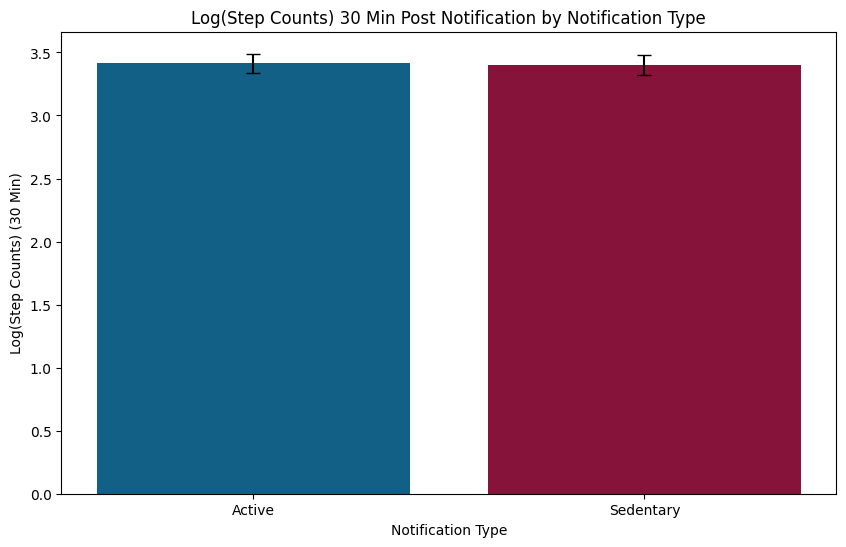

In [15]:
#====================================================================
# JAWBONE DATA: total steps 30 min after notif (jbsteps30)
#====================================================================
# we need to do the same thing as the steps we did above, but now for the steps 30-min post the notification
# print(mydata_steps_gf[['jbsteps30', 'notif_type', 'user.index']].isnull().sum())
# Filter out rows where 'jbsteps30' is NaN
# Filter out rows where 'jbsteps30' or 'jbsteps60' are NaN
# mydata_steps_gf = mydata_steps_gf.dropna(subset=['jbsteps30', 'jbsteps60']).reset_index(drop=True)
# mydata_steps_gf = mydata_steps_gf

from statsmodels.formula.api import mixedlm

# Define the model and fit (approximate approach using MixedLM)
model_jb30_glmm = mixedlm("jbsteps_30 ~ notif_type", mydata_steps_gf, groups=mydata_steps_gf["user.index"])
result_jb30 = model_jb30_glmm.fit()
print(result_jb30.summary())

# # Add predicted values into dataframe and 
# # Create a summary of predicted values for plotting
# mydata_steps_gf['predicted_steps_30'] = result_jb30.predict()
# predictions_summary_30 = mydata_steps_gf.groupby('notif_type').agg(
#     mean_pred=('predicted_steps_30', 'mean'),
#     lower_ci=('predicted_steps_30', lambda x: np.quantile(x, 0.025)),
#     upper_ci=('predicted_steps_30', lambda x: np.quantile(x, 0.975)),
#     se_pred=('predicted_steps_30', lambda x: np.std(x) / np.sqrt(len(x)))
# ).reset_index()

# # Plot PREDICTED values for jbsteps30
# plt.figure(figsize=(10, 6))
# sns.barplot(data=predictions_summary_30, x="notif_type", y="mean_pred", palette={"Active": "#006699", "Sedentary": "#990033"})
# plt.errorbar(predictions_summary_30['notif_type'], predictions_summary_30['mean_pred'], 
#              yerr=predictions_summary_30['se_pred'], fmt='none', color='black', capsize=5)
# plt.title("Predicted Step Counts 30 Min Post Notification by Notification Type")
# plt.xlabel("Notification Type")
# plt.ylabel("Predicted Step Counts (30 Min)")
# plt.savefig(os.path.join(figure_dir, "pred_rq1_30min.png"), transparent=True)
# plt.show()

# Add OBSERVED values into dataframe and create a summary for plotting
observed_summary_30 = mydata_steps_gf.groupby('notif_type').agg(
    mean_obs=('jbsteps_30', 'mean'),
    lower_ci=('jbsteps_30', lambda x: np.quantile(x, 0.025)),
    upper_ci=('jbsteps_30', lambda x: np.quantile(x, 0.975)),
    se_obs=('jbsteps_30', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot OBSERVED values for jbsteps30
plt.figure(figsize=(10, 6))
sns.barplot(data=observed_summary_30, x="notif_type", y="mean_obs", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(observed_summary_30['notif_type'], observed_summary_30['mean_obs'], 
             yerr=observed_summary_30['se_obs'], fmt='none', color='black', capsize=5)
plt.title("Observed Step Counts 30 Min Post Notification by Notification Type")
plt.xlabel("Notification Type")
plt.ylabel("Observed Step Counts (30 Min)")
plt.savefig(os.path.join(figure_dir, "obs_rq1_30min_JB.png"), transparent=True)
plt.show()



#log-transformed JB 30
from statsmodels.formula.api import mixedlm

# Define the model and fit (approximate approach using MixedLM)
model_jb30_glmm_log = mixedlm("log_jbsteps_30 ~ notif_type", mydata_steps_gf, groups=mydata_steps_gf["user.index"])
result_jb30_log = model_jb30_glmm_log.fit()
print(result_jb30_log.summary())


# Add OBSERVED values into dataframe and create a summary for plotting
observed_summary_30 = mydata_steps_gf.groupby('notif_type').agg(
    mean_obs=('log_jbsteps_30', 'mean'),
    lower_ci=('log_jbsteps_30', lambda x: np.quantile(x, 0.025)),
    upper_ci=('log_jbsteps_30', lambda x: np.quantile(x, 0.975)),
    se_obs=('log_jbsteps_30', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot OBSERVED values for jbsteps30
plt.figure(figsize=(10, 6))
sns.barplot(data=observed_summary_30, x="notif_type", y="mean_obs", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(observed_summary_30['notif_type'], observed_summary_30['mean_obs'], 
             yerr=observed_summary_30['se_obs'], fmt='none', color='black', capsize=5)
plt.title("Log(Step Counts) 30 Min Post Notification by Notification Type")
plt.xlabel("Notification Type")
plt.ylabel("Log(Step Counts) (30 Min)")
plt.savefig(os.path.join(figure_dir, "obs_rq1_30min_log_JB.png"), transparent=True)
plt.show()


/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_79487/3251993723.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_summary_60 = mydata_steps_gf.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


                 Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     jbsteps_60 
No. Observations:       2512        Method:                 REML       
No. Groups:             25          Scale:                  668690.5257
Min. group size:        23          Log-Likelihood:         -20423.5694
Max. group size:        134         Converged:              Yes        
Mean group size:        100.5                                          
-----------------------------------------------------------------------
                          Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
Intercept                 551.599   44.245 12.467 0.000 464.880 638.318
notif_type[T.Sedentary]    13.010   33.143  0.393 0.695 -51.949  77.970
Group Var               34907.075   14.747                             



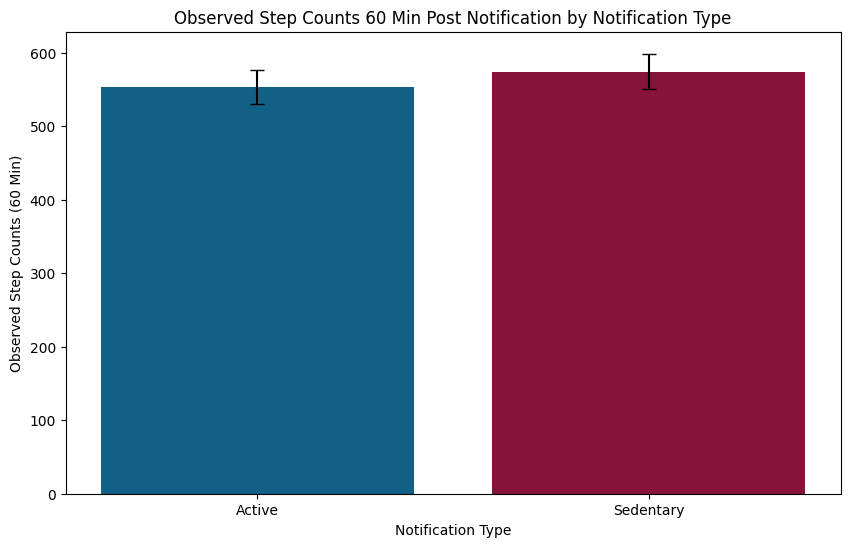

/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_79487/3251993723.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_summary_60 = mydata_steps_gf.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   log_jbsteps_60
No. Observations:   2512      Method:               REML          
No. Groups:         25        Scale:                6.7886        
Min. group size:    23        Log-Likelihood:       -5993.6750    
Max. group size:    134       Converged:            Yes           
Mean group size:    100.5                                         
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                4.658    0.140 33.170 0.000  4.383  4.933
notif_type[T.Sedentary] -0.033    0.106 -0.310 0.757 -0.240  0.174
Group Var                0.350    0.048                           



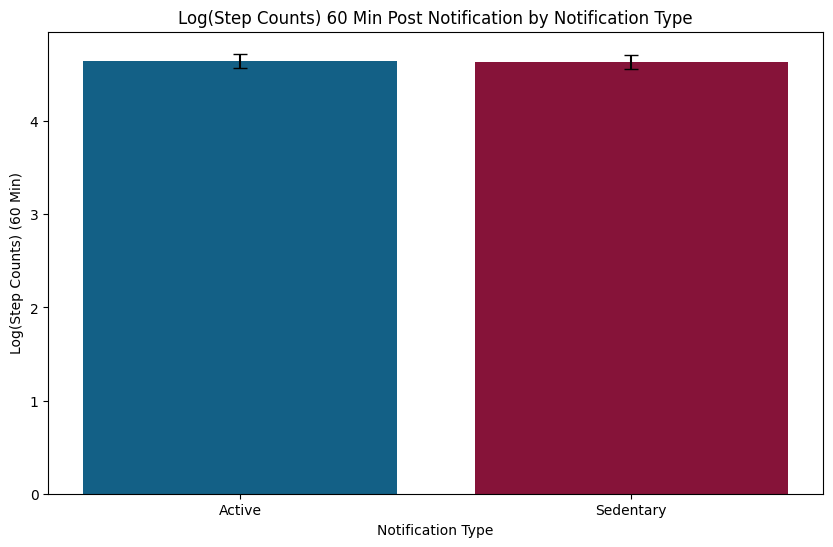

In [16]:
#====================================================================
# JAWBONE DATA: total steps 60 min after notif (jbsteps60)
#====================================================================
# we need to do the same thing as the steps we did above, but now for the steps 60-min post the notification
# print(mydata_steps_gf[['jbsteps60', 'notif_type', 'user.index']].isnull().sum())
# Filter out rows where 'jbsteps60' is NaN
# Filter out rows where 'jbsteps60' or 'jbsteps60' are NaN
# mydata_steps_gf = mydata_steps_gf.dropna(subset=['jbsteps60', 'jbsteps60']).reset_index(drop=True)
# mydata_steps_gf = mydata_steps_gf

from statsmodels.formula.api import mixedlm

# Define the model and fit (approximate approach using MixedLM)
model_jb60_glmm = mixedlm("jbsteps_60 ~ notif_type", mydata_steps_gf, groups=mydata_steps_gf["user.index"])
result_jb60 = model_jb60_glmm.fit()
print(result_jb60.summary())

# # Add predicted values into dataframe and 
# # Create a summary of predicted values for plotting
# mydata_steps_gf['predicted_steps_60'] = result_jb60.predict()
# predictions_summary_60 = mydata_steps_gf.groupby('notif_type').agg(
#     mean_pred=('predicted_steps_60', 'mean'),
#     lower_ci=('predicted_steps_60', lambda x: np.quantile(x, 0.025)),
#     upper_ci=('predicted_steps_60', lambda x: np.quantile(x, 0.975)),
#     se_pred=('predicted_steps_60', lambda x: np.std(x) / np.sqrt(len(x)))
# ).reset_index()

# # Plot PREDICTED values for jbsteps60
# plt.figure(figsize=(10, 6))
# sns.barplot(data=predictions_summary_60, x="notif_type", y="mean_pred", palette={"Active": "#006699", "Sedentary": "#990033"})
# plt.errorbar(predictions_summary_60['notif_type'], predictions_summary_60['mean_pred'], 
#              yerr=predictions_summary_60['se_pred'], fmt='none', color='black', capsize=5)
# plt.title("Predicted Step Counts 60 Min Post Notification by Notification Type")
# plt.xlabel("Notification Type")
# plt.ylabel("Predicted Step Counts (60 Min)")
# plt.savefig(os.path.join(figure_dir, "pred_rq1_60min.png"), transparent=True)
# plt.show()

# Add OBSERVED values into dataframe and create a summary for plotting
observed_summary_60 = mydata_steps_gf.groupby('notif_type').agg(
    mean_obs=('jbsteps_60', 'mean'),
    lower_ci=('jbsteps_60', lambda x: np.quantile(x, 0.025)),
    upper_ci=('jbsteps_60', lambda x: np.quantile(x, 0.975)),
    se_obs=('jbsteps_60', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot OBSERVED values for jbsteps60
plt.figure(figsize=(10, 6))
sns.barplot(data=observed_summary_60, x="notif_type", y="mean_obs", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(observed_summary_60['notif_type'], observed_summary_60['mean_obs'], 
             yerr=observed_summary_60['se_obs'], fmt='none', color='black', capsize=5)
plt.title("Observed Step Counts 60 Min Post Notification by Notification Type")
plt.xlabel("Notification Type")
plt.ylabel("Observed Step Counts (60 Min)")
plt.savefig(os.path.join(figure_dir, "obs_rq1_60min_JB.png"), transparent=True)
plt.show()



#log-transformed JB 60
from statsmodels.formula.api import mixedlm

# Define the model and fit (approximate approach using MixedLM)
model_jb60_glmm_log = mixedlm("log_jbsteps_60 ~ notif_type", mydata_steps_gf, groups=mydata_steps_gf["user.index"])
result_jb60_log = model_jb60_glmm_log.fit()
print(result_jb60_log.summary())


# Add OBSERVED values into dataframe and create a summary for plotting
observed_summary_60 = mydata_steps_gf.groupby('notif_type').agg(
    mean_obs=('log_jbsteps_60', 'mean'),
    lower_ci=('log_jbsteps_60', lambda x: np.quantile(x, 0.025)),
    upper_ci=('log_jbsteps_60', lambda x: np.quantile(x, 0.975)),
    se_obs=('log_jbsteps_60', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot OBSERVED values for jbsteps60
plt.figure(figsize=(10, 6))
sns.barplot(data=observed_summary_60, x="notif_type", y="mean_obs", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(observed_summary_60['notif_type'], observed_summary_60['mean_obs'], 
             yerr=observed_summary_60['se_obs'], fmt='none', color='black', capsize=5)
plt.title("Log(Step Counts) 60 Min Post Notification by Notification Type")
plt.xlabel("Notification Type")
plt.ylabel("Log(Step Counts) (60 Min)")
plt.savefig(os.path.join(figure_dir, "obs_rq1_60min_log_JB.png"), transparent=True)
plt.show()


## Log transformation on steps_30 and steps_60:

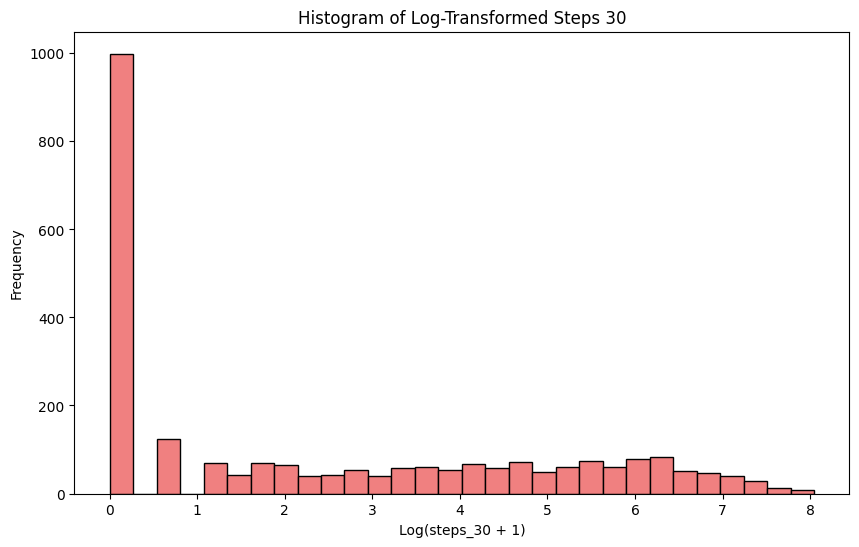

              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   log_steps_30
No. Observations:    2512      Method:               REML        
No. Groups:          25        Scale:                6.1267      
Min. group size:     23        Log-Likelihood:       -5862.2719  
Max. group size:     134       Converged:            Yes         
Mean group size:     100.5                                       
-----------------------------------------------------------------
                        Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               2.349    0.121 19.363 0.000  2.111  2.587
notif_type[T.Sedentary] 0.105    0.100  1.052 0.293 -0.091  0.302
Group Var               0.240    0.036                           



/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_79487/2798904179.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predictions_summary_log_30 = mydata_steps_gf_log.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


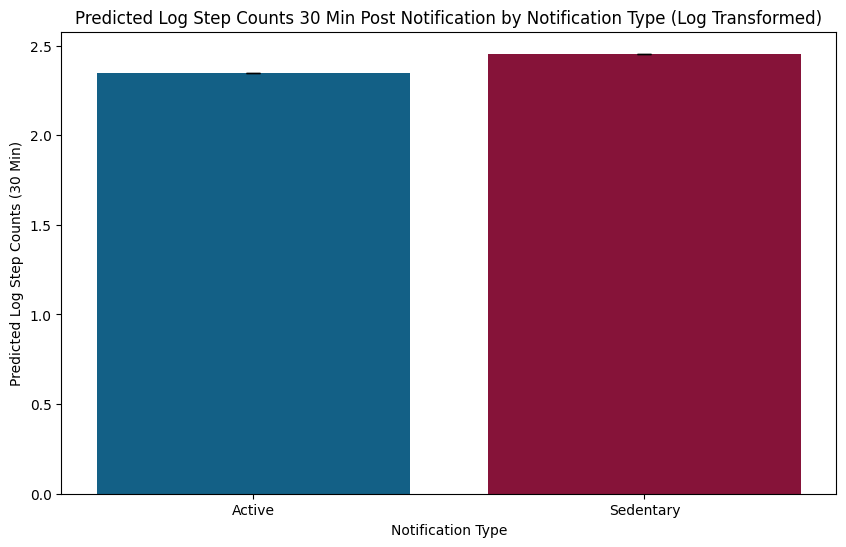

/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_79487/2798904179.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_summary_log_30 = mydata_steps_gf_log.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


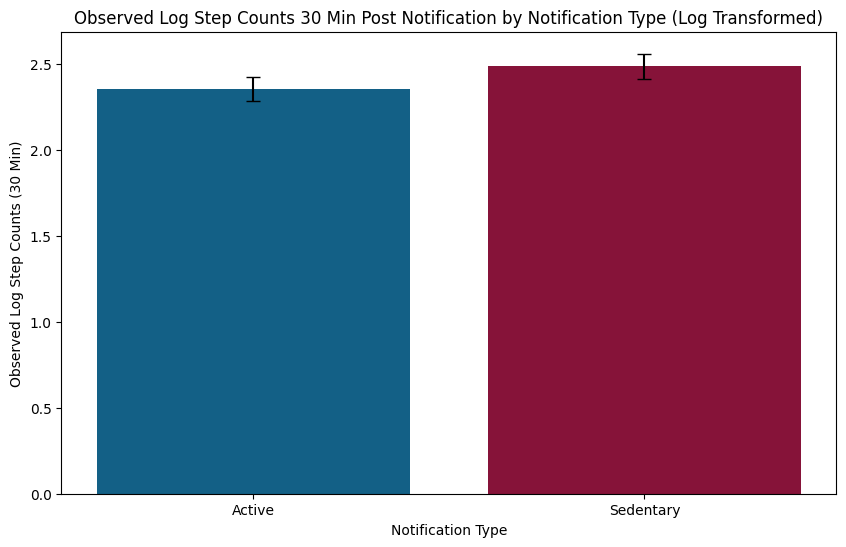

In [18]:
# Copy data and apply log transformation
mydata_steps_gf_log = mydata_steps_gf.copy()
mydata_steps_gf_log['log_steps_30'] = np.log1p(mydata_steps_gf_log['gfsteps_30'])

# Plot histogram of the log-transformed `steps_30`
plt.figure(figsize=(10, 6))
plt.hist(mydata_steps_gf_log['log_steps_30'], bins=30, color='lightcoral', edgecolor='black')
plt.title("Histogram of Log-Transformed Steps 30")
plt.xlabel("Log(steps_30 + 1)")
plt.ylabel("Frequency")
plt.show()

# Define the model with log-transformed steps_30 and fit
model_gf30_glmm_log = mixedlm("log_steps_30 ~ notif_type", mydata_steps_gf_log, groups=mydata_steps_gf_log["user.index"])
result_gf30_log = model_gf30_glmm_log.fit()
print(result_gf30_log.summary())

# Add predicted values for the log-transformed model
mydata_steps_gf_log['predicted_log_steps_30'] = result_gf30_log.predict()
predictions_summary_log_30 = mydata_steps_gf_log.groupby('notif_type').agg(
    mean_pred_log=('predicted_log_steps_30', 'mean'),
    lower_ci_log=('predicted_log_steps_30', lambda x: np.quantile(x, 0.025)),
    upper_ci_log=('predicted_log_steps_30', lambda x: np.quantile(x, 0.975)),
    se_pred_log=('predicted_log_steps_30', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot PREDICTED values for log-transformed gfsteps30
plt.figure(figsize=(10, 6))
sns.barplot(data=predictions_summary_log_30, x="notif_type", y="mean_pred_log", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(predictions_summary_log_30['notif_type'], predictions_summary_log_30['mean_pred_log'], 
             yerr=predictions_summary_log_30['se_pred_log'], fmt='none', color='black', capsize=5)
plt.title("Predicted Log Step Counts 30 Min Post Notification by Notification Type (Log Transformed)")
plt.xlabel("Notification Type")
plt.ylabel("Predicted Log Step Counts (30 Min)")
plt.savefig(os.path.join(figure_dir, "pred_log_rq1_30min.png"), transparent=True)
plt.show()

# Create summary of OBSERVED log-transformed values for plotting
observed_summary_log_30 = mydata_steps_gf_log.groupby('notif_type').agg(
    mean_obs_log=('log_steps_30', 'mean'),
    lower_ci_log=('log_steps_30', lambda x: np.quantile(x, 0.025)),
    upper_ci_log=('log_steps_30', lambda x: np.quantile(x, 0.975)),
    se_obs_log=('log_steps_30', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot OBSERVED log-transformed values for gfsteps30
plt.figure(figsize=(10, 6))
sns.barplot(data=observed_summary_log_30, x="notif_type", y="mean_obs_log", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(observed_summary_log_30['notif_type'], observed_summary_log_30['mean_obs_log'], 
             yerr=observed_summary_log_30['se_obs_log'], fmt='none', color='black', capsize=5)
plt.title("Observed Log Step Counts 30 Min Post Notification by Notification Type (Log Transformed)")
plt.xlabel("Notification Type")
plt.ylabel("Observed Log Step Counts (30 Min)")
plt.savefig(os.path.join(figure_dir, "obs_log_rq1_30min.png"), transparent=True)
plt.show()

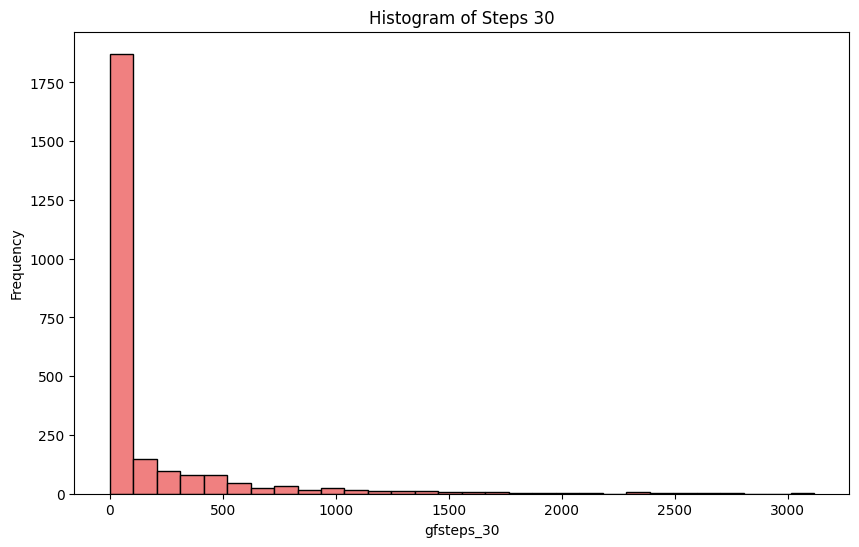

                 Generalized Linear Model Regression Results                  
Dep. Variable:             gfsteps_30   No. Observations:                 2512
Model:                            GLM   Df Residuals:                     2510
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15152.
Date:                Tue, 05 Nov 2024   Deviance:                       15272.
Time:                        21:49:45   Pearson chi2:                 1.33e+04
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01216
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_79487/3478033577.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predictions_summary_nb_30 = mydata_steps_gf_nb.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


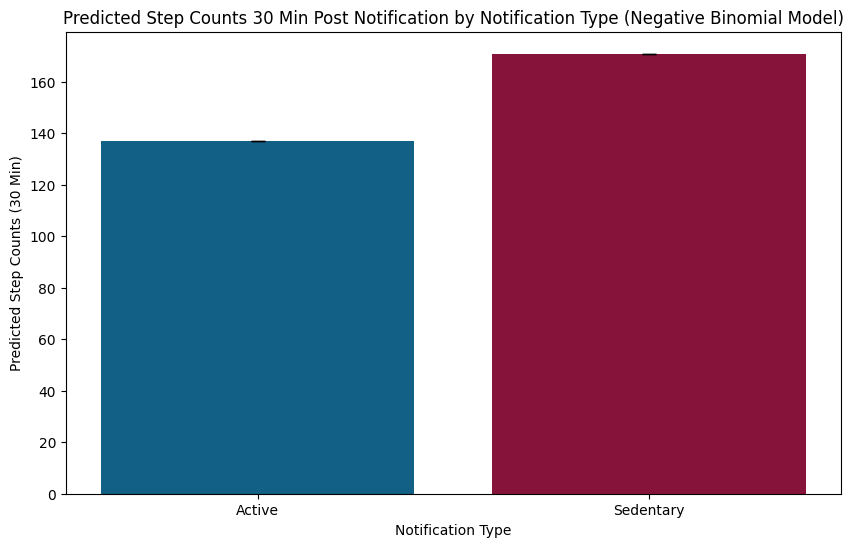

/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_79487/3478033577.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_summary_nb_30 = mydata_steps_gf_nb.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


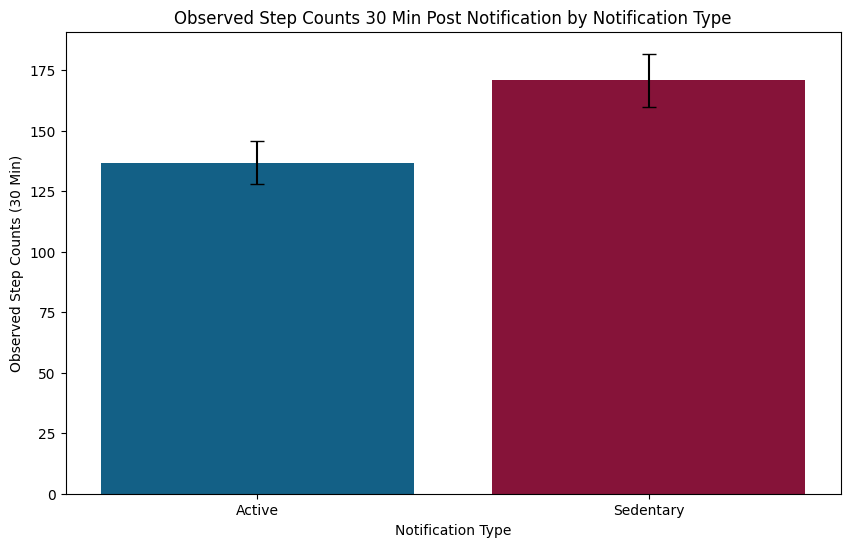

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.formula.api import glm
import statsmodels.api as sm

# Copy data (optional) for transformation
mydata_steps_gf_nb = mydata_steps_gf.copy()

# Plot histogram of the original `steps_30`
plt.figure(figsize=(10, 6))
plt.hist(mydata_steps_gf_nb['gfsteps_30'], bins=30, color='lightcoral', edgecolor='black')
plt.title("Histogram of Steps 30")
plt.xlabel("gfsteps_30")
plt.ylabel("Frequency")
plt.show()

# Define and fit the Negative Binomial GLM as an approximation for GLMM
model_gf30_nb_glmm = glm("gfsteps_30 ~ notif_type", data=mydata_steps_gf_nb, 
                         family=sm.families.NegativeBinomial()).fit()
print(model_gf30_nb_glmm.summary())

# Add predicted values for Negative Binomial GLM model
mydata_steps_gf_nb['predicted_steps_30_nb'] = model_gf30_nb_glmm.predict()
predictions_summary_nb_30 = mydata_steps_gf_nb.groupby('notif_type').agg(
    mean_pred_nb=('predicted_steps_30_nb', 'mean'),
    lower_ci_nb=('predicted_steps_30_nb', lambda x: np.quantile(x, 0.025)),
    upper_ci_nb=('predicted_steps_30_nb', lambda x: np.quantile(x, 0.975)),
    se_pred_nb=('predicted_steps_30_nb', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot PREDICTED values for steps_30 using Negative Binomial model
plt.figure(figsize=(10, 6))
sns.barplot(data=predictions_summary_nb_30, x="notif_type", y="mean_pred_nb", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(predictions_summary_nb_30['notif_type'], predictions_summary_nb_30['mean_pred_nb'], 
             yerr=predictions_summary_nb_30['se_pred_nb'], fmt='none', color='black', capsize=5)
plt.title("Predicted Step Counts 30 Min Post Notification by Notification Type (Negative Binomial Model)")
plt.xlabel("Notification Type")
plt.ylabel("Predicted Step Counts (30 Min)")
plt.savefig(os.path.join(figure_dir, "pred_nb_rq1_30min.png"), transparent=True)
plt.show()

# Create summary of OBSERVED values for plotting
observed_summary_nb_30 = mydata_steps_gf_nb.groupby('notif_type').agg(
    mean_obs=('gfsteps_30', 'mean'),
    lower_ci=('gfsteps_30', lambda x: np.quantile(x, 0.025)),
    upper_ci=('gfsteps_30', lambda x: np.quantile(x, 0.975)),
    se_obs=('gfsteps_30', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot OBSERVED values for steps_30
plt.figure(figsize=(10, 6))
sns.barplot(data=observed_summary_nb_30, x="notif_type", y="mean_obs", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(observed_summary_nb_30['notif_type'], observed_summary_nb_30['mean_obs'], 
             yerr=observed_summary_nb_30['se_obs'], fmt='none', color='black', capsize=5)
plt.title("Observed Step Counts 30 Min Post Notification by Notification Type")
plt.xlabel("Notification Type")
plt.ylabel("Observed Step Counts (30 Min)")
plt.savefig(os.path.join(figure_dir, "obs_nb_rq1_30min.png"), transparent=True)
plt.show()


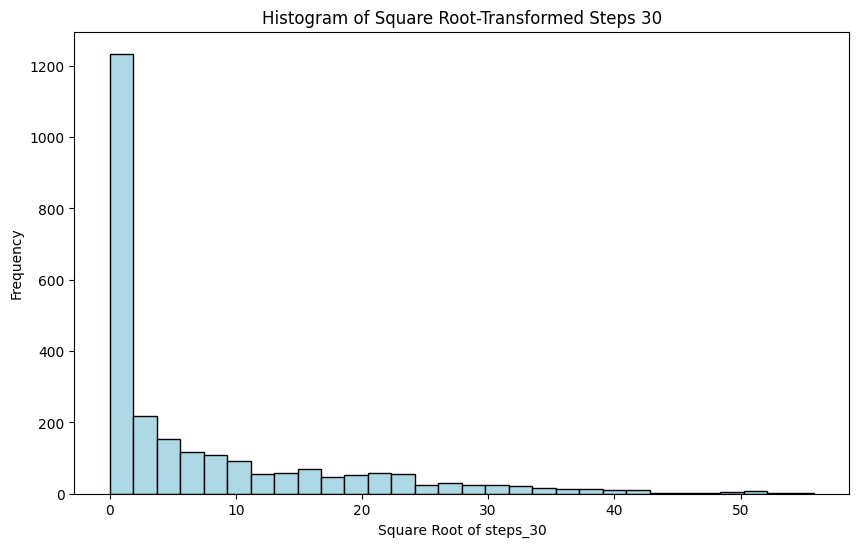

              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   sqrt_steps_30
No. Observations:   2512      Method:               REML         
No. Groups:         25        Scale:                99.4265      
Min. group size:    23        Log-Likelihood:       -9360.8100   
Max. group size:    134       Converged:            Yes          
Mean group size:    100.5                                        
-----------------------------------------------------------------
                        Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               6.561    0.509 12.890 0.000  5.563  7.558
notif_type[T.Sedentary] 0.708    0.404  1.751 0.080 -0.084  1.500
Group Var               4.396    0.156                           



/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import mixedlm

# Apply square root transformation to the `steps_30` column
mydata_steps_gf_sqrt = mydata_steps_gf.copy()
mydata_steps_gf_sqrt['sqrt_steps_30'] = np.sqrt(mydata_steps_gf_sqrt['gfsteps_30'])

# Plot histogram of the square root-transformed `steps_30`
plt.figure(figsize=(10, 6))
plt.hist(mydata_steps_gf_sqrt['sqrt_steps_30'], bins=30, color='lightblue', edgecolor='black')
plt.title("Histogram of Square Root-Transformed Steps 30")
plt.xlabel("Square Root of steps_30")
plt.ylabel("Frequency")
plt.show()

# Define the model using the square root-transformed steps_30 and fit
model_gf30_sqrt_glmm = mixedlm("sqrt_steps_30 ~ notif_type", mydata_steps_gf_sqrt, groups=mydata_steps_gf_sqrt["user.index"])
result_gf30_sqrt = model_gf30_sqrt_glmm.fit()
print(result_gf30_sqrt.summary())


In [26]:
# # Copy data and apply log transformation to steps_60
# mydata_steps_gf_30_60_log = mydata_steps_gf_30_60.copy()
# mydata_steps_gf_30_60_log['log_steps_60'] = np.log1p(mydata_steps_gf_30_60_log['gfsteps_60'])

# # Plot histogram of the log-transformed `steps_60`
# plt.figure(figsize=(10, 6))
# plt.hist(mydata_steps_gf_30_60_log['log_steps_60'], bins=30, color='skyblue', edgecolor='black')
# plt.title("Histogram of Log-Transformed Steps 60")
# plt.xlabel("Log(steps_60 + 1)")
# plt.ylabel("Frequency")
# plt.show()

# # Define the model with log-transformed steps_60 and fit
# model_gf60_glmm_log = mixedlm("log_steps_60 ~ notif_type", mydata_steps_gf_30_60_log, groups=mydata_steps_gf_30_60_log["user.index"])
# result_gf60_log = model_gf60_glmm_log.fit()
# print(result_gf60_log.summary())

# # Add predicted values for the log-transformed model
# mydata_steps_gf_30_60_log['predicted_log_steps_60'] = result_gf60_log.predict()
# predictions_summary_log_60 = mydata_steps_gf_30_60_log.groupby('notif_type').agg(
#     mean_pred_log=('predicted_log_steps_60', 'mean'),
#     lower_ci_log=('predicted_log_steps_60', lambda x: np.quantile(x, 0.025)),
#     upper_ci_log=('predicted_log_steps_60', lambda x: np.quantile(x, 0.975)),
#     se_pred_log=('predicted_log_steps_60', lambda x: np.std(x) / np.sqrt(len(x)))
# ).reset_index()

# # Plot PREDICTED values for log-transformed steps_60
# plt.figure(figsize=(10, 6))
# sns.barplot(data=predictions_summary_log_60, x="notif_type", y="mean_pred_log", palette={"Active": "#006699", "Sedentary": "#990033"})
# plt.errorbar(predictions_summary_log_60['notif_type'], predictions_summary_log_60['mean_pred_log'], 
#              yerr=predictions_summary_log_60['se_pred_log'], fmt='none', color='black', capsize=5)
# plt.title("Predicted Log Step Counts 60 Min Post Notification by Notification Type (Log Transformed)")
# plt.xlabel("Notification Type")
# plt.ylabel("Predicted Log Step Counts (60 Min)")
# plt.savefig(os.path.join(figure_dir, "pred_log_rq1_60min.png"), transparent=True)
# plt.show()

# # Create summary of OBSERVED log-transformed values for plotting
# observed_summary_log_60 = mydata_steps_gf_30_60_log.groupby('notif_type').agg(
#     mean_obs_log=('log_steps_60', 'mean'),
#     lower_ci_log=('log_steps_60', lambda x: np.quantile(x, 0.025)),
#     upper_ci_log=('log_steps_60', lambda x: np.quantile(x, 0.975)),
#     se_obs_log=('log_steps_60', lambda x: np.std(x) / np.sqrt(len(x)))
# ).reset_index()

# # Plot OBSERVED log-transformed values for steps_60
# plt.figure(figsize=(10, 6))
# sns.barplot(data=observed_summary_log_60, x="notif_type", y="mean_obs_log", palette={"Active": "#006699", "Sedentary": "#990033"})
# plt.errorbar(observed_summary_log_60['notif_type'], observed_summary_log_60['mean_obs_log'], 
#              yerr=observed_summary_log_60['se_obs_log'], fmt='none', color='black', capsize=5)
# plt.title("Observed Log Step Counts 60 Min Post Notification by Notification Type (Log Transformed)")
# plt.xlabel("Notification Type")
# plt.ylabel("Observed Log Step Counts (60 Min)")
# plt.savefig(os.path.join(figure_dir, "obs_log_rq1_60min.png"), transparent=True)
# plt.show()


## RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts

For this, basically we want to add the interaction term between self_efficacy (as discrete variable: low, medium, and high) into the models above. 
- GF:  
    - 30 after ~ notif_type * self_efficacy
    - 60 after ~ notif_type * self_efficacy

- JAWBONE: 
    - 30 after ~ notif_type * self_efficacy
    - 60 after ~ notif_type * self_efficacy


0.25    12.0
0.50    16.0
0.75    18.0
Name: selfeff_intake_r, dtype: float64
                              Mixed Linear Model Regression Results
Model:                          MixedLM              Dependent Variable:              total_steps
No. Observations:               2512                 Method:                          REML       
No. Groups:                     25                   Scale:                           9667.7179  
Min. group size:                23                   Log-Likelihood:                  -15110.5633
Max. group size:                134                  Converged:                       Yes        
Mean group size:                100.5                                                            
-------------------------------------------------------------------------------------------------
                                                    Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------------

/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_79487/275643702.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['notif_type', 'selfeff_category'])
/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_79487/275643702.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['notif_type', 'selfeff_category'])
/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_79487/275643702.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to ado

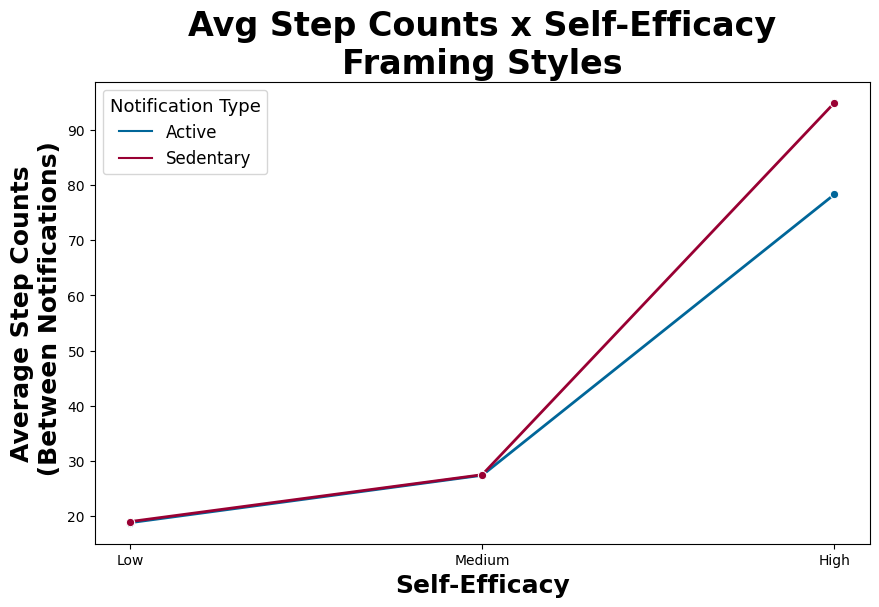

/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

                              Mixed Linear Model Regression Results
Model:                          MixedLM              Dependent Variable:              gfsteps_30 
No. Observations:               2512                 Method:                          REML       
No. Groups:                     25                   Scale:                           121153.6325
Min. group size:                23                   Log-Likelihood:                  -18258.3344
Max. group size:                134                  Converged:                       Yes        
Mean group size:                100.5                                                            
-------------------------------------------------------------------------------------------------
                                                    Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------------------------------
Intercept                                         

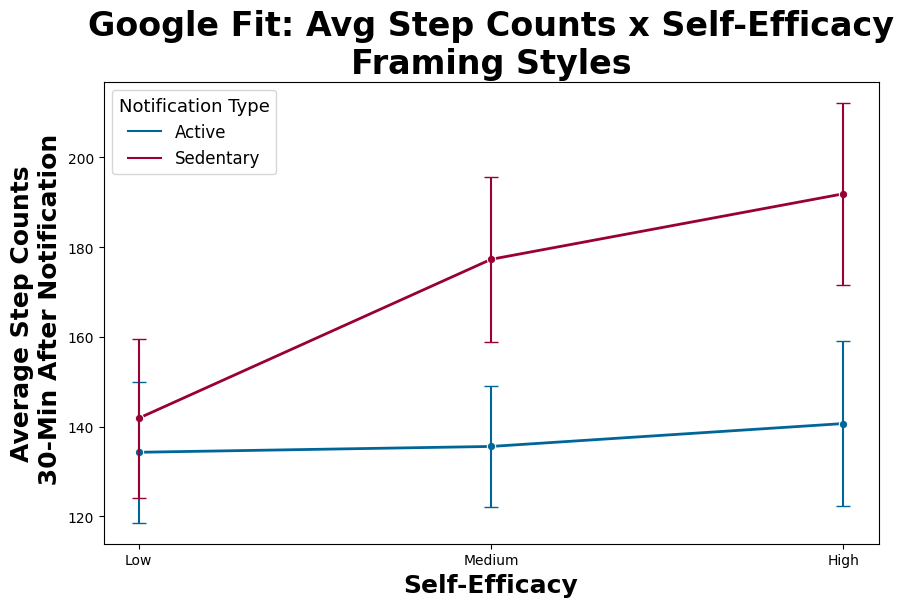

/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

                            Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            log_gfsteps_30
No. Observations:            2512               Method:                        REML          
No. Groups:                  25                 Scale:                         6.1231        
Min. group size:             23                 Log-Likelihood:                -5862.2708    
Max. group size:             134                Converged:                     Yes           
Mean group size:             100.5                                                           
---------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------
Intercept                                           2.495    0.223 11.174 0.000  2.057  

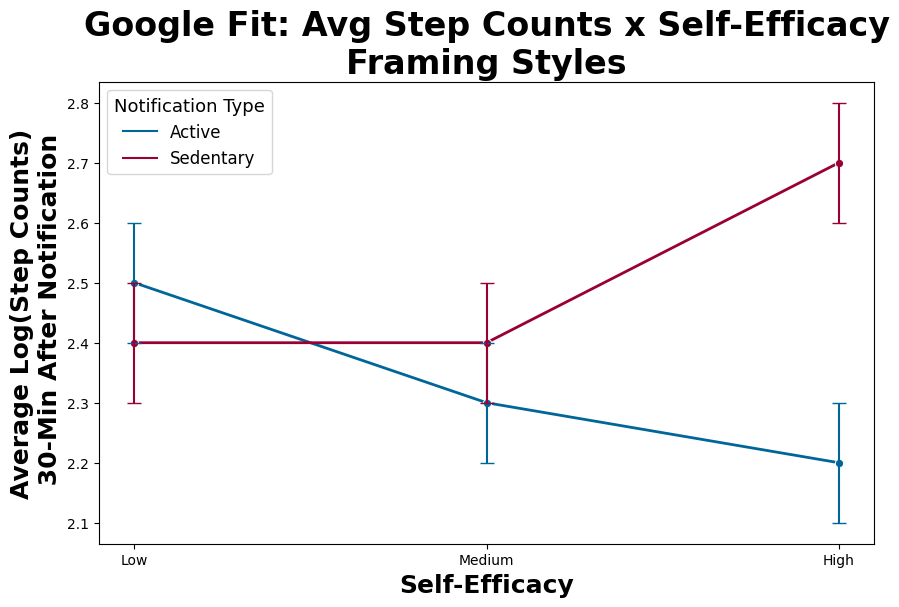

/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

                               Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               jbsteps_60 
No. Observations:               2512                  Method:                           REML       
No. Groups:                     25                    Scale:                            669156.2731
Min. group size:                23                    Log-Likelihood:                   -20400.9473
Max. group size:                134                   Converged:                        Yes        
Mean group size:                100.5                                                              
---------------------------------------------------------------------------------------------------
                                                     Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
---------------------------------------------------------------------------------------------------
Intercept                      

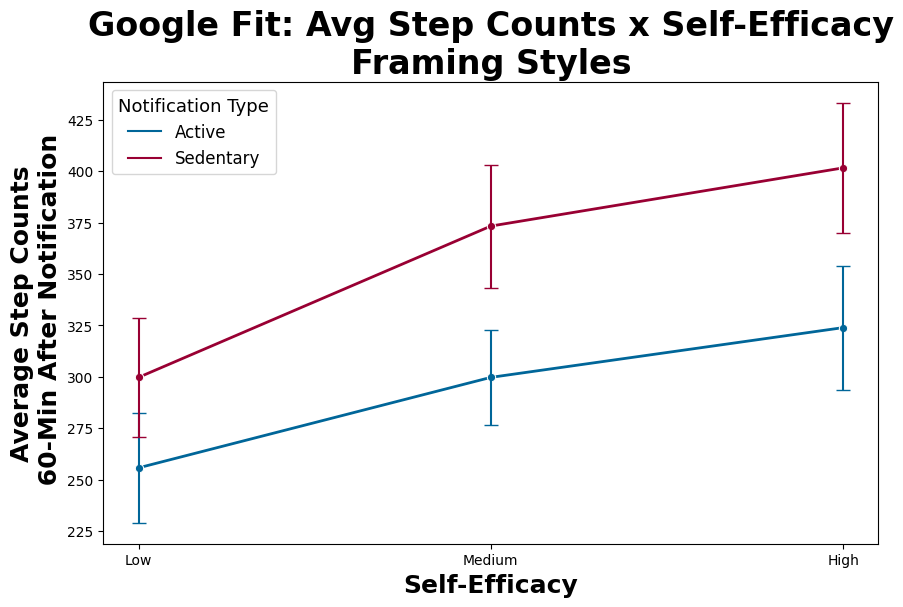

/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

                            Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            log_gfsteps_60
No. Observations:            2512               Method:                        REML          
No. Groups:                  25                 Scale:                         6.6902        
Min. group size:             23                 Log-Likelihood:                -5979.6025    
Max. group size:             134                Converged:                     Yes           
Mean group size:             100.5                                                           
---------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------
Intercept                                           3.435    0.300 11.466 0.000  2.848  

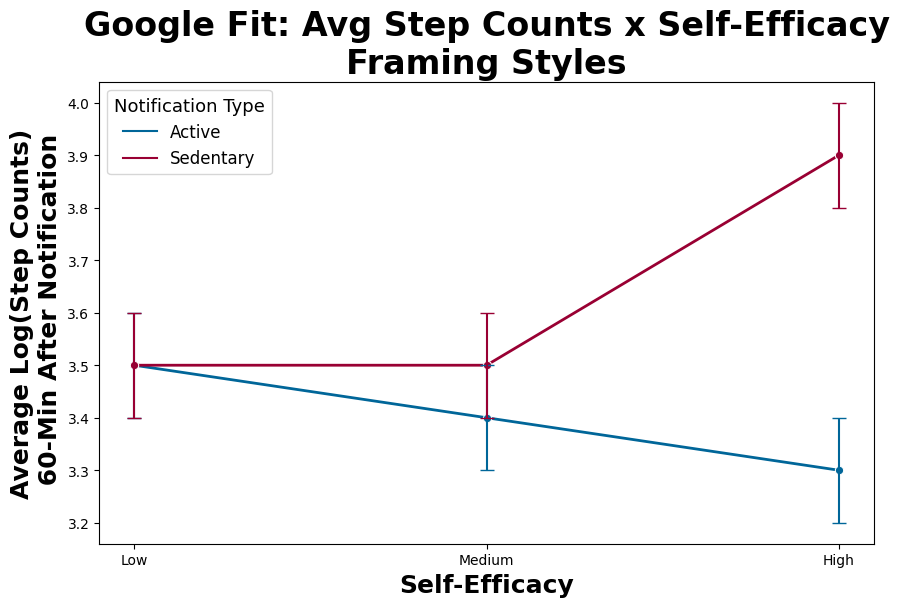

In [27]:
#====================================================================
# RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts
# GF: total_steps between notif
#====================================================================

# load data
# mydata_steps_gf_30_60 <- pd.read_csv(os.path.join(data_dir, "mydata_steps_gf_py.csv"))
mydata_steps_gf['user.index'] = mydata_steps_gf['user.index'].astype('category')
mydata_steps_gf['notif_type'] = mydata_steps_gf['notif_type'].astype('category')

# Define self efficacy as a discrete variable based on its quantile
# low (<=13), med (14-17 inclusive), high (>=18)
selfeff_intake_quantiles = mydata_steps_gf['selfeff_intake_r'].quantile([0.25, 0.5, 0.75])
print(selfeff_intake_quantiles)

# Categorize selfeff.intake_r for visualization
# low (<=13), med (14-17 inclusive), high (>=18)
mydata_steps_gf['selfeff_category'] = pd.cut(
    mydata_steps_gf['selfeff_intake_r'], bins=[-np.inf, 14, 18, np.inf], labels=["Low", "Medium", "High"], right=False
)

# Create summary table
SUMM_mydata_steps_gf = (
    mydata_steps_gf
    .groupby(['notif_type', 'selfeff_category'])
    .agg(
        n=('total_steps', 'size'),
        mean=('total_steps', lambda x: round(np.mean(x), 1)),
        sd=('total_steps', lambda x: round(np.std(x), 1)),
        se=('total_steps', lambda x: round(np.std(x) / np.sqrt(x.notna().sum()), 1)),
        IQR=('total_steps', lambda x: round(np.percentile(x, 75) - np.percentile(x, 25), 1))
    )
    .reset_index()
)

# print(SUMM_mydata_steps_gf)

# Create summary table
SUMM_mydata_steps_gf_30 = (
    mydata_steps_gf
    .groupby(['notif_type', 'selfeff_category'])
    .agg(
        n_gf30=('gfsteps_30', 'size'),
        mean_gf30=('gfsteps_30', lambda x: round(np.mean(x), 1)),
        sd_gf30=('gfsteps_30', lambda x: round(np.std(x), 1)),
        se_gf30=('gfsteps_30', lambda x: round(np.std(x) / np.sqrt(x.notna().sum()), 1)),
        IQR_gf30=('gfsteps_30', lambda x: round(np.percentile(x, 75) - np.percentile(x, 25), 1))
    )
    .reset_index()
)

# print(SUMM_mydata_steps_gf_30)


# Create summary table
SUMM_mydata_steps_gf_30_log = (
    mydata_steps_gf
    .groupby(['notif_type', 'selfeff_category'])
    .agg(
        n_gf30_log=('log_gfsteps_30', 'size'),
        mean_gf30_log=('log_gfsteps_30', lambda x: round(np.mean(x), 1)),
        sd_gf30_log=('log_gfsteps_30', lambda x: round(np.std(x), 1)),
        se_gf30_log=('log_gfsteps_30', lambda x: round(np.std(x) / np.sqrt(x.notna().sum()), 1)),
        IQR_gf30_log=('log_gfsteps_30', lambda x: round(np.percentile(x, 75) - np.percentile(x, 25), 1))
    )
    .reset_index()
)

# print(SUMM_mydata_steps_gf_30_log)


# Create summary table
SUMM_mydata_steps_gf_60 = (
    mydata_steps_gf
    .groupby(['notif_type', 'selfeff_category'])
    .agg(
        n_gf60=('gfsteps_60', 'size'),
        mean_gf60=('gfsteps_60', lambda x: round(np.mean(x), 1)),
        sd_gf60=('gfsteps_60', lambda x: round(np.std(x), 1)),
        se_gf60=('gfsteps_60', lambda x: round(np.std(x) / np.sqrt(x.notna().sum()), 1)),
        IQR_gf60=('gfsteps_60', lambda x: round(np.percentile(x, 75) - np.percentile(x, 25), 1))
    )
    .reset_index()
)

# print(SUMM_mydata_steps_gf_60)


# Create summary table
SUMM_mydata_steps_gf_60_log = (
    mydata_steps_gf
    .groupby(['notif_type', 'selfeff_category'])
    .agg(
        n_gf60_log=('log_gfsteps_60', 'size'),
        mean_gf60_log=('log_gfsteps_60', lambda x: round(np.mean(x), 1)),
        sd_gf60_log=('log_gfsteps_60', lambda x: round(np.std(x), 1)),
        se_gf60_log=('log_gfsteps_60', lambda x: round(np.std(x) / np.sqrt(x.notna().sum()), 1)),
        IQR_gf60_log=('log_gfsteps_60', lambda x: round(np.percentile(x, 75) - np.percentile(x, 25), 1))
    )
    .reset_index()
)

# print(SUMM_mydata_steps_gf_60_log)




from statsmodels.formula.api import mixedlm
# Define the model and fit (approximate approach using MixedLM)
model_nb_glmm_notifxselfeff = mixedlm("total_steps ~ notif_type * selfeff_category", mydata_steps_gf, groups=mydata_steps_gf["user.index"])
result = model_nb_glmm_notifxselfeff.fit()
print(result.summary())


# Plot interaction effects (no interaction :( sadly)
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=SUMM_mydata_steps_gf, x="selfeff_category", y="mean", hue="notif_type", 
    marker="o", palette={"Active": "#006699", "Sedentary": "#990033"}, linewidth=2
)
plt.title("Avg Step Counts x Self-Efficacy\nFraming Styles", fontsize=24, fontweight='bold')
plt.xlabel("Self-Efficacy", fontsize=18, fontweight='bold')
plt.ylabel("Average Step Counts\n (Between Notifications)", fontsize=18, fontweight='bold')
plt.legend(title="Notification Type", fontsize=12, title_fontsize='13')

# Save the plot
plt.savefig(os.path.join(figure_dir,"notif_selfeff_steps_bwnotif.png"), transparent=True)
plt.show()


#====================================================================
# RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts
# GF: total_steps 30 min after notif
#====================================================================
# Define the model and fit (approximate approach using MixedLM)
model_nb_glmm_notifxselfeff_30 = mixedlm("gfsteps_30 ~ notif_type * selfeff_category", mydata_steps_gf, groups=mydata_steps_gf["user.index"])
result = model_nb_glmm_notifxselfeff_30.fit()
print(result.summary())


# Plot interaction effects (no interaction :( sadly)
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=SUMM_mydata_steps_gf_30, x="selfeff_category", y="mean_gf30", hue="notif_type", 
    marker="o", palette={"Active": "#006699", "Sedentary": "#990033"}, linewidth=2
)

# Manually add error bars using matplotlib's plt.errorbar, with offset to avoid overlapping bars
for i, notif_type in enumerate(SUMM_mydata_steps_gf_30['notif_type'].unique()):
    subset = SUMM_mydata_steps_gf_30[SUMM_mydata_steps_gf_30['notif_type'] == notif_type]
    plt.errorbar(
        subset['selfeff_category'],  # Shift x-values to avoid overlap
        subset['mean_gf30'],                                # y-values
        yerr=subset['se_gf30'],                             # Error bars
        fmt='none',                                             # No additional markers
        capsize=5,                                              # Adds caps at the end of error bars
        color={"Active": "#006699", "Sedentary": "#990033"}[notif_type]
    )
plt.title("Google Fit: Avg Step Counts x Self-Efficacy\nFraming Styles", fontsize=24, fontweight='bold')
plt.xlabel("Self-Efficacy", fontsize=18, fontweight='bold')
plt.ylabel("Average Step Counts\n 30-Min After Notification", fontsize=18, fontweight='bold')
plt.legend(title="Notification Type", fontsize=12, title_fontsize='13')

# Save the plot
plt.savefig(os.path.join(figure_dir,"notif_selfeff_steps_gf30.png"), transparent=True)
plt.show()



#====================================================================
# LOG TRANSFORMATION 
# RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts
# GF: total_steps 30 min after notif
#====================================================================
# Define the model and fit (approximate approach using MixedLM)
model_nb_glmm_notifxselfeff_30_log = mixedlm("log_gfsteps_30 ~ notif_type * selfeff_category", mydata_steps_gf, groups=mydata_steps_gf["user.index"])
result = model_nb_glmm_notifxselfeff_30_log.fit()
print(result.summary())


# Plot interaction effects (no interaction :( sadly)
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=SUMM_mydata_steps_gf_30_log, x="selfeff_category", y="mean_gf30_log", hue="notif_type", 
    marker="o", palette={"Active": "#006699", "Sedentary": "#990033"}, linewidth=2
)

# Manually add error bars using matplotlib's plt.errorbar, with offset to avoid overlapping bars
for i, notif_type in enumerate(SUMM_mydata_steps_gf_30_log['notif_type'].unique()):
    subset = SUMM_mydata_steps_gf_30_log[SUMM_mydata_steps_gf_30_log['notif_type'] == notif_type]
    plt.errorbar(
        subset['selfeff_category'],  # Shift x-values to avoid overlap
        subset['mean_gf30_log'],                                # y-values
        yerr=subset['se_gf30_log'],                             # Error bars
        fmt='none',                                             # No additional markers
        capsize=5,                                              # Adds caps at the end of error bars
        color={"Active": "#006699", "Sedentary": "#990033"}[notif_type]
    )

plt.title("Google Fit: Avg Step Counts x Self-Efficacy\nFraming Styles", fontsize=24, fontweight='bold')
plt.xlabel("Self-Efficacy", fontsize=18, fontweight='bold')
plt.ylabel("Average Log(Step Counts)\n 30-Min After Notification", fontsize=18, fontweight='bold')
plt.legend(title="Notification Type", fontsize=12, title_fontsize='13')

# Save the plot
plt.savefig(os.path.join(figure_dir,"notif_selfeff_steps_gf30_log.png"), transparent=True)
plt.show()


#====================================================================
# RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts
# JB: total_steps 60 min after notif
#====================================================================
# Define the model and fit (approximate approach using MixedLM)
model_nb_glmm_notifxselfeff_60 = mixedlm("jbsteps_60 ~ notif_type * selfeff_category", mydata_steps_gf, groups=mydata_steps_gf["user.index"])
result = model_nb_glmm_notifxselfeff_60.fit()
print(result.summary())


# Plot interaction effects (no interaction :( sadly)
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=SUMM_mydata_steps_gf_60, x="selfeff_category", y="mean_gf60", hue="notif_type", 
    marker="o", palette={"Active": "#006699", "Sedentary": "#990033"}, linewidth=2
)

# Manually add error bars using matplotlib's plt.errorbar, with offset to avoid overlapping bars
for i, notif_type in enumerate(SUMM_mydata_steps_gf_60['notif_type'].unique()):
    subset = SUMM_mydata_steps_gf_60[SUMM_mydata_steps_gf_60['notif_type'] == notif_type]
    plt.errorbar(
        subset['selfeff_category'],  # Shift x-values to avoid overlap
        subset['mean_gf60'],                                # y-values
        yerr=subset['se_gf60'],                             # Error bars
        fmt='none',                                             # No additional markers
        capsize=5,                                              # Adds caps at the end of error bars
        color={"Active": "#006699", "Sedentary": "#990033"}[notif_type]
    )

plt.title("Google Fit: Avg Step Counts x Self-Efficacy\nFraming Styles", fontsize=24, fontweight='bold')
plt.xlabel("Self-Efficacy", fontsize=18, fontweight='bold')
plt.ylabel("Average Step Counts\n 60-Min After Notification", fontsize=18, fontweight='bold')
plt.legend(title="Notification Type", fontsize=12, title_fontsize='13')

# Save the plot
plt.savefig(os.path.join(figure_dir,"notif_selfeff_steps_gf60.png"), transparent=True)
plt.show()



#====================================================================
# LOG TRANSFORMATION 
# RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts
# GF: total_steps 60 min after notif
#====================================================================
# Define the model and fit (approximate approach using MixedLM)
model_nb_glmm_notifxselfeff_60_log = mixedlm("log_gfsteps_60 ~ notif_type * selfeff_category", mydata_steps_gf, groups=mydata_steps_gf["user.index"])
result = model_nb_glmm_notifxselfeff_60_log.fit()
print(result.summary())


# Plot interaction effects (no interaction :( sadly)
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=SUMM_mydata_steps_gf_60_log, x="selfeff_category", y="mean_gf60_log", hue="notif_type", 
    marker="o", palette={"Active": "#006699", "Sedentary": "#990033"}, linewidth=2
)

# Manually add error bars using matplotlib's plt.errorbar, with offset to avoid overlapping bars
for i, notif_type in enumerate(SUMM_mydata_steps_gf_60_log['notif_type'].unique()):
    subset = SUMM_mydata_steps_gf_60_log[SUMM_mydata_steps_gf_60_log['notif_type'] == notif_type]
    plt.errorbar(
        subset['selfeff_category'],  # Shift x-values to avoid overlap
        subset['mean_gf60_log'],                                # y-values
        yerr=subset['se_gf60_log'],                             # Error bars
        fmt='none',                                             # No additional markers
        capsize=5,                                              # Adds caps at the end of error bars
        color={"Active": "#006699", "Sedentary": "#990033"}[notif_type]
    )

plt.title("Google Fit: Avg Step Counts x Self-Efficacy\nFraming Styles", fontsize=24, fontweight='bold')
plt.xlabel("Self-Efficacy", fontsize=18, fontweight='bold')
plt.ylabel("Average Log(Step Counts)\n 60-Min After Notification", fontsize=18, fontweight='bold')
plt.legend(title="Notification Type", fontsize=12, title_fontsize='13')

# Save the plot
plt.savefig(os.path.join(figure_dir,"notif_selfeff_steps_gf60_log.png"), transparent=True)
plt.show()



## Jawbone Data

0.25    12.0
0.50    16.0
0.75    18.0
Name: selfeff_intake_r, dtype: float64


/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_79487/2057129561.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['notif_type', 'selfeff_category'])
/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_79487/2057129561.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['notif_type', 'selfeff_category'])
/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_79487/2057129561.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to 

                              Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              jbsteps_30 
No. Observations:                2512                 Method:                          REML       
No. Groups:                      25                   Scale:                           227922.3875
Min. group size:                 23                   Log-Likelihood:                  -19048.1749
Max. group size:                 134                  Converged:                       Yes        
Mean group size:                 100.5                                                            
--------------------------------------------------------------------------------------------------
                                                    Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

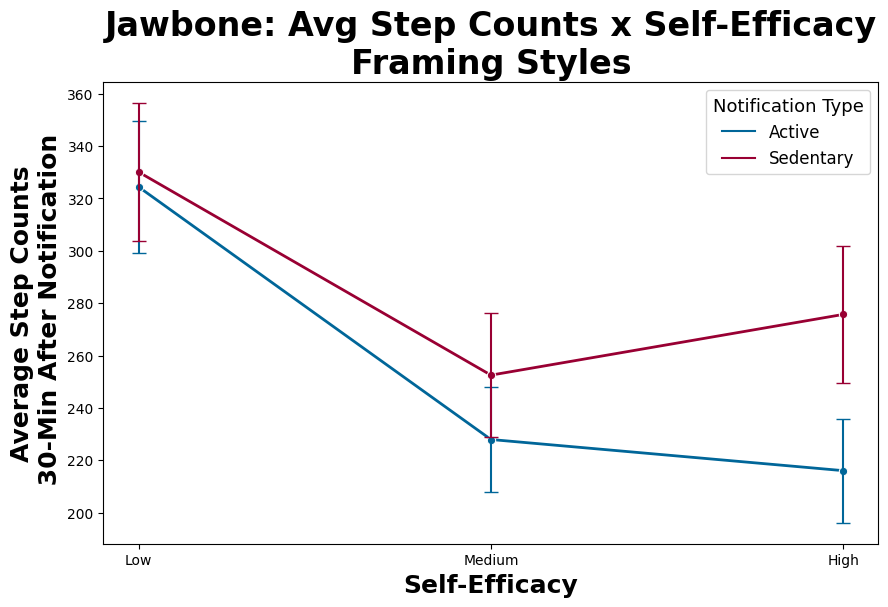

/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

                            Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            log_jbsteps_30
No. Observations:            2512               Method:                        REML          
No. Groups:                  25                 Scale:                         7.3395        
Min. group size:             23                 Log-Likelihood:                -6087.2744    
Max. group size:             134                Converged:                     Yes           
Mean group size:             100.5                                                           
---------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------
Intercept                                           3.839    0.227 16.942 0.000  3.395  

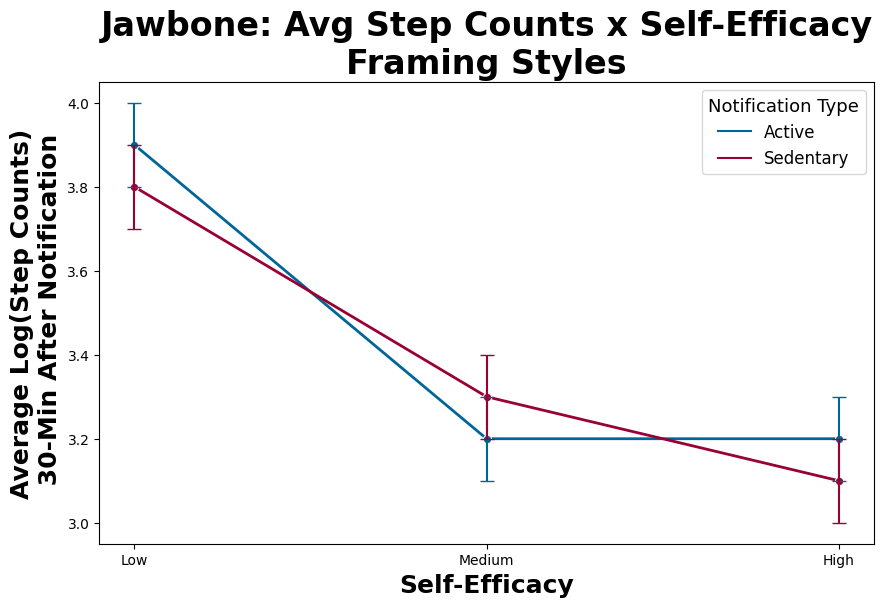

/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

                               Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               jbsteps_60 
No. Observations:               2512                  Method:                           REML       
No. Groups:                     25                    Scale:                            669156.2731
Min. group size:                23                    Log-Likelihood:                   -20400.9473
Max. group size:                134                   Converged:                        Yes        
Mean group size:                100.5                                                              
---------------------------------------------------------------------------------------------------
                                                     Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
---------------------------------------------------------------------------------------------------
Intercept                      

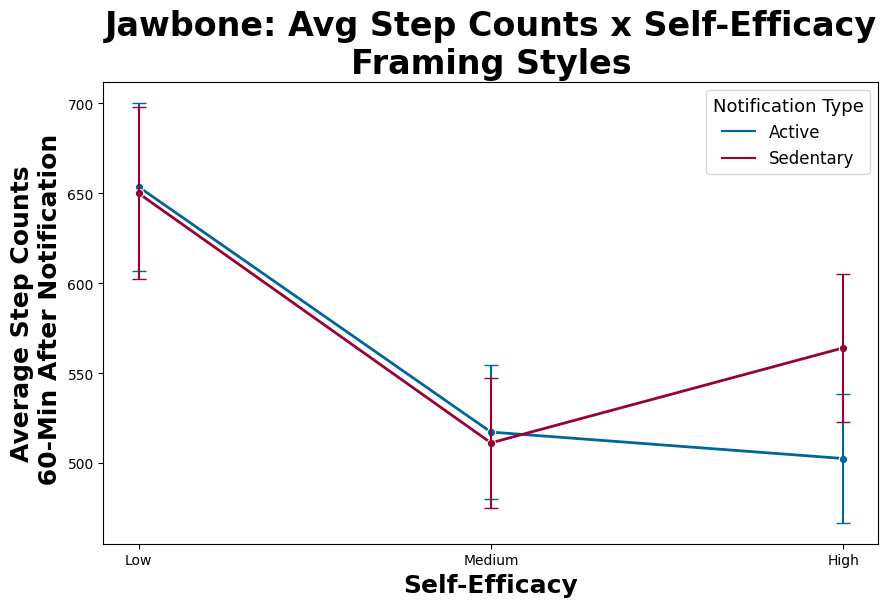

/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

                            Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            log_jbsteps_60
No. Observations:            2512               Method:                        REML          
No. Groups:                  25                 Scale:                         6.7947        
Min. group size:             23                 Log-Likelihood:                -5994.1587    
Max. group size:             134                Converged:                     Yes           
Mean group size:             100.5                                                           
---------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------
Intercept                                           4.939    0.249 19.853 0.000  4.452  

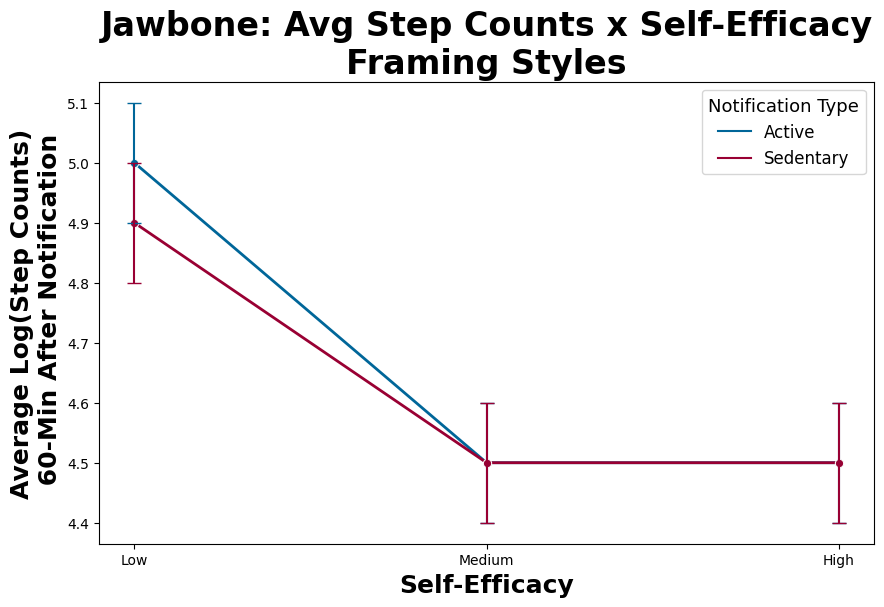

In [28]:

# load data
# mydata_steps_gf_30_60 <- pd.read_csv(os.path.join(data_dir, "mydata_steps_gf_py.csv"))
mydata_steps_gf['user.index'] = mydata_steps_gf['user.index'].astype('category')
mydata_steps_gf['notif_type'] = mydata_steps_gf['notif_type'].astype('category')

# Define self efficacy as a discrete variable based on its quantile
# low (<=13), med (14-17 inclusive), high (>=18)
selfeff_intake_quantiles = mydata_steps_gf['selfeff_intake_r'].quantile([0.25, 0.5, 0.75])
print(selfeff_intake_quantiles)

# Categorize selfeff.intake_r for visualization
# low (<=13), med (14-17 inclusive), high (>=18)
mydata_steps_gf['selfeff_category'] = pd.cut(
    mydata_steps_gf['selfeff_intake_r'], bins=[-np.inf, 14, 18, np.inf], labels=["Low", "Medium", "High"], right=False
)


# Create summary table
SUMM_mydata_steps_jb_30 = (
    mydata_steps_gf
    .groupby(['notif_type', 'selfeff_category'])
    .agg(
        n_jb30=('jbsteps_30', 'size'),
        mean_jb30=('jbsteps_30', lambda x: round(np.mean(x), 1)),
        sd_jb30=('jbsteps_30', lambda x: round(np.std(x), 1)),
        se_jb30=('jbsteps_30', lambda x: round(np.std(x) / np.sqrt(x.notna().sum()), 1)),
        IQR_jb30=('jbsteps_30', lambda x: round(np.percentile(x, 75) - np.percentile(x, 25), 1))
    )
    .reset_index()
)

# print(SUMM_mydata_steps_jb_30)

# Create summary table
SUMM_mydata_steps_jb_30_log = (
    mydata_steps_gf
    .groupby(['notif_type', 'selfeff_category'])
    .agg(
        n_jb30_log=('log_jbsteps_30', 'size'),
        mean_jb30_log=('log_jbsteps_30', lambda x: round(np.mean(x), 1)),
        sd_jb30_log=('log_jbsteps_30', lambda x: round(np.std(x), 1)),
        se_jb30_log=('log_jbsteps_30', lambda x: round(np.std(x) / np.sqrt(x.notna().sum()), 1)),
        IQR_jb30_log=('log_jbsteps_30', lambda x: round(np.percentile(x, 75) - np.percentile(x, 25), 1))
    )
    .reset_index()
)

# print(SUMM_mydata_steps_jb_30_log)

# Create summary table
SUMM_mydata_steps_jb_60 = (
    mydata_steps_gf
    .groupby(['notif_type', 'selfeff_category'])
    .agg(
        n_jb60=('jbsteps_60', 'size'),
        mean_jb60=('jbsteps_60', lambda x: round(np.mean(x), 1)),
        sd_jb60=('jbsteps_60', lambda x: round(np.std(x), 1)),
        se_jb60=('jbsteps_60', lambda x: round(np.std(x) / np.sqrt(x.notna().sum()), 1)),
        IQR_jb60=('jbsteps_60', lambda x: round(np.percentile(x, 75) - np.percentile(x, 25), 1))
    )
    .reset_index()
)

# print(SUMM_mydata_steps_jb_60)

# Create summary table
SUMM_mydata_steps_jb_60_log = (
    mydata_steps_gf
    .groupby(['notif_type', 'selfeff_category'])
    .agg(
        n_jb60_log=('log_jbsteps_60', 'size'),
        mean_jb60_log=('log_jbsteps_60', lambda x: round(np.mean(x), 1)),
        sd_jb60_log=('log_jbsteps_60', lambda x: round(np.std(x), 1)),
        se_jb60_log=('log_jbsteps_60', lambda x: round(np.std(x) / np.sqrt(x.notna().sum()), 1)),
        IQR_jb60_log=('log_jbsteps_60', lambda x: round(np.percentile(x, 75) - np.percentile(x, 25), 1))
    )
    .reset_index()
)

# print(SUMM_mydata_steps_jb_60_log)

#====================================================================
# RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts
# JB: total_steps 30 min after notif
#====================================================================
# Define the model and fit (approximate approach using MixedLM)
model_nb_glmm_notifxselfeff_30 = mixedlm("jbsteps_30 ~ notif_type * selfeff_category", mydata_steps_gf, groups=mydata_steps_gf["user.index"])
result = model_nb_glmm_notifxselfeff_30.fit()
print(result.summary())

# Plot interaction effects (no interaction :( sadly)
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=SUMM_mydata_steps_jb_30, x="selfeff_category", y="mean_jb30", hue="notif_type", 
    marker="o", palette={"Active": "#006699", "Sedentary": "#990033"}, linewidth=2
)

# Manually add error bars using matplotlib's plt.errorbar, with offset to avoid overlapping bars
for i, notif_type in enumerate(SUMM_mydata_steps_jb_30['notif_type'].unique()):
    subset = SUMM_mydata_steps_jb_30[SUMM_mydata_steps_jb_30['notif_type'] == notif_type]
    plt.errorbar(
        subset['selfeff_category'],  # Shift x-values to avoid overlap
        subset['mean_jb30'],                                # y-values
        yerr=subset['se_jb30'],                             # Error bars
        fmt='none',                                             # No additional markers
        capsize=5,                                              # Adds caps at the end of error bars
        color={"Active": "#006699", "Sedentary": "#990033"}[notif_type]
    )
plt.title("Jawbone: Avg Step Counts x Self-Efficacy\nFraming Styles", fontsize=24, fontweight='bold')
plt.xlabel("Self-Efficacy", fontsize=18, fontweight='bold')
plt.ylabel("Average Step Counts\n 30-Min After Notification", fontsize=18, fontweight='bold')
plt.legend(title="Notification Type", fontsize=12, title_fontsize='13')

# Save the plot
plt.savefig(os.path.join(figure_dir,"notif_selfeff_steps_jb30.png"), transparent=True)
plt.show()

#====================================================================
# LOG TRANSFORMATION 
# RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts
# JB: total_steps 30 min after notif
#====================================================================
# Define the model and fit (approximate approach using MixedLM)
model_nb_glmm_notifxselfeff_30_log = mixedlm("log_jbsteps_30 ~ notif_type * selfeff_category", mydata_steps_gf, groups=mydata_steps_gf["user.index"])
result = model_nb_glmm_notifxselfeff_30_log.fit()
print(result.summary())

# Plot interaction effects (no interaction :( sadly)
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=SUMM_mydata_steps_jb_30_log, x="selfeff_category", y="mean_jb30_log", hue="notif_type", 
    marker="o", palette={"Active": "#006699", "Sedentary": "#990033"}, linewidth=2
)

# Manually add error bars using matplotlib's plt.errorbar, with offset to avoid overlapping bars
for i, notif_type in enumerate(SUMM_mydata_steps_jb_30_log['notif_type'].unique()):
    subset = SUMM_mydata_steps_jb_30_log[SUMM_mydata_steps_jb_30_log['notif_type'] == notif_type]
    plt.errorbar(
        subset['selfeff_category'],  # Shift x-values to avoid overlap
        subset['mean_jb30_log'],                                # y-values
        yerr=subset['se_jb30_log'],                             # Error bars
        fmt='none',                                             # No additional markers
        capsize=5,                                              # Adds caps at the end of error bars
        color={"Active": "#006699", "Sedentary": "#990033"}[notif_type]
    )

plt.title("Jawbone: Avg Step Counts x Self-Efficacy\nFraming Styles", fontsize=24, fontweight='bold')
plt.xlabel("Self-Efficacy", fontsize=18, fontweight='bold')
plt.ylabel("Average Log(Step Counts)\n 30-Min After Notification", fontsize=18, fontweight='bold')
plt.legend(title="Notification Type", fontsize=12, title_fontsize='13')

# Save the plot
plt.savefig(os.path.join(figure_dir,"notif_selfeff_steps_jb30_log.png"), transparent=True)
plt.show()

#====================================================================
# RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts
# JB: total_steps 60 min after notif
#====================================================================
# Define the model and fit (approximate approach using MixedLM)
model_nb_glmm_notifxselfeff_60 = mixedlm("jbsteps_60 ~ notif_type * selfeff_category", mydata_steps_gf, groups=mydata_steps_gf["user.index"])
result = model_nb_glmm_notifxselfeff_60.fit()
print(result.summary())

# Plot interaction effects (no interaction :( sadly)
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=SUMM_mydata_steps_jb_60, x="selfeff_category", y="mean_jb60", hue="notif_type", 
    marker="o", palette={"Active": "#006699", "Sedentary": "#990033"}, linewidth=2
)

# Manually add error bars using matplotlib's plt.errorbar, with offset to avoid overlapping bars
for i, notif_type in enumerate(SUMM_mydata_steps_jb_60['notif_type'].unique()):
    subset = SUMM_mydata_steps_jb_60[SUMM_mydata_steps_jb_60['notif_type'] == notif_type]
    plt.errorbar(
        subset['selfeff_category'],  # Shift x-values to avoid overlap
        subset['mean_jb60'],                                # y-values
        yerr=subset['se_jb60'],                             # Error bars
        fmt='none',                                             # No additional markers
        capsize=5,                                              # Adds caps at the end of error bars
        color={"Active": "#006699", "Sedentary": "#990033"}[notif_type]
    )

plt.title("Jawbone: Avg Step Counts x Self-Efficacy\nFraming Styles", fontsize=24, fontweight='bold')
plt.xlabel("Self-Efficacy", fontsize=18, fontweight='bold')
plt.ylabel("Average Step Counts\n 60-Min After Notification", fontsize=18, fontweight='bold')
plt.legend(title="Notification Type", fontsize=12, title_fontsize='13')

# Save the plot
plt.savefig(os.path.join(figure_dir,"notif_selfeff_steps_jb60.png"), transparent=True)
plt.show()

#====================================================================
# LOG TRANSFORMATION 
# RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts
# JB: total_steps 60 min after notif
#====================================================================
# Define the model and fit (approximate approach using MixedLM)
model_nb_glmm_notifxselfeff_60_log = mixedlm("log_jbsteps_60 ~ notif_type * selfeff_category", mydata_steps_gf, groups=mydata_steps_gf["user.index"])
result = model_nb_glmm_notifxselfeff_60_log.fit()
print(result.summary())

# Plot interaction effects (no interaction :( sadly)
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=SUMM_mydata_steps_jb_60_log, x="selfeff_category", y="mean_jb60_log", hue="notif_type", 
    marker="o", palette={"Active": "#006699", "Sedentary": "#990033"}, linewidth=2
)

# Manually add error bars using matplotlib's plt.errorbar, with offset to avoid overlapping bars
for i, notif_type in enumerate(SUMM_mydata_steps_jb_60_log['notif_type'].unique()):
    subset = SUMM_mydata_steps_jb_60_log[SUMM_mydata_steps_jb_60_log['notif_type'] == notif_type]
    plt.errorbar(
        subset['selfeff_category'],  # Shift x-values to avoid overlap
        subset['mean_jb60_log'],                                # y-values
        yerr=subset['se_jb60_log'],                             # Error bars
        fmt='none',                                             # No additional markers
        capsize=5,                                              # Adds caps at the end of error bars
        color={"Active": "#006699", "Sedentary": "#990033"}[notif_type]
    )

plt.title("Jawbone: Avg Step Counts x Self-Efficacy\nFraming Styles", fontsize=24, fontweight='bold')
plt.xlabel("Self-Efficacy", fontsize=18, fontweight='bold')
plt.ylabel("Average Log(Step Counts)\n 60-Min After Notification", fontsize=18, fontweight='bold')
plt.legend(title="Notification Type", fontsize=12, title_fontsize='13')

# Save the plot
plt.savefig(os.path.join(figure_dir,"notif_selfeff_steps_jb60_log.png"), transparent=True)
plt.show()
